# Hoja de problemas 1


* Student 1: Gorka Crespo Bravo
* Student 2: Miguel Cuesta Altable
* Student 3: Antón Salvadores Muñiz

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy import stats
from scipy.stats import norm, lognorm, t, chi2, skew, kurtosis
from scipy.optimize import minimize

import statsmodels.api as sm
import statsmodels.graphics.tsaplots as sgt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf, pacf, adfuller, acovf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.stats.sandwich_covariance import cov_hac_simple

from HW01_Econometría_functions import (
    simulate_normal_distributions,
    simulate_t_student_distributions,
    acf_pacf,
    pred)

#Ejercicio 1

El contraste de Normalidad de Bera–Jarque especifica que el estadístico
$JB = \frac{T}{6}\Big(S^2 + \tfrac{1}{4}(K-3)^2\Big)$ se distribuye asintóticamente como una chi–cuadrado con 2 grados de libertad,
bajo la hipótesis nula de que los datos son extracciones independientes
de una población Normal con esperanza matemática y varianza desconocidas. En la expresión anterior, $S$ denota el coeficiente de asimetría y $K$ denota el coeficiente de curtosis, mientras que $T$ es el tamaño muestral. Este ejercicio consiste en comparar el tamaño (o probabilidad de cometer error de tipo $I$) y la potencia del contraste empíricos con sus valores teóricos.

 1. Simule un elevado número de muestras de tamaño $T=20$ de una población Normal con determinada esperanza y varianza que debe fijar de antemano. Puede elegir cualquier par de valores, pero manténgalos fijos para todas las muestras. Escoja un nivel de significación del $1 \%$, y calcule el porcentaje de veces que rechaza la hipótesis nula. Este número es una estimación del tamaño del contraste, por lo que debería aproximarse a $0.01$; sin embargo, el hecho de que la muestra sea corta, hará que la aproximación sea imperfecta.
 2. Repita el ejercicio con las mismas muestras, para niveles de significación del $5\%$ y del $10\%$.
 3. Repita el ejercicio con muestras de tamaño $T=50$ y $T=100$.
 4. Construya una tabla que resuma todos los tamaños empíricos que ha obtenido en este ejercicio, y examine en qué grado se separan de sus valores teóricos.
 5. Para contrastar potencia, hemos de simular distribuciones no Normales (recuerde que la potencia de un contraste es la probabilidad de rechazar la hipótesis nula cuando esta es falsa). Diseñe un ejercicio extrayendo muestras de una población no Normal (por ejemplo de distribuciones $t$ de Student con pocos grados de libertad). Y calcule la potencia para los mismos casos de antes: nivel de significación del $1\%$, $5\%$ y $10\%$, y tamaños muestrales $T = 20, 50, 100$.



**Resolución**

In [ ]:
T = [20, 50, 100]                # Distintos tamaños de las muestras

N = [100, 1000, 10000]           # Distintos tamaños muestrales

mu = 0.0                         # Media de las distribuciones
sigma = 1.0                      # Desviación típica de las distribuciones

alpha = [0.01, 0.05, 0.10]       # Distintos niveles de significación

In [ ]:
samples = np.zeros((len(N), len(T)), dtype=object) # Inicializamos para almacenar las muestras

In [ ]:
for i in range(len(N)):
    for j in range(len(T)):
        samples[i, j] = simulate_normal_distributions(                # En cada fila almacenamos los distintos tamaños muestrales (100, 1000, 10000)
            n_times=T[j], n_samples=N[i], mean=mu, stdev=sigma)       # y en cada columna los distintos tamaños de cada muestra (20, 50, 100).

**Resultados de la estimación del tamaño del contraste**


In [ ]:
results = np.zeros((len(N), len(T), len(alpha)), dtype=object)       # Inicializamos un array para guardar los resultados
                                                                     # de las muestras para los distintos niveles de significación
                                                                     # alpha. Así, cada elemento de este array indicará la proporción de
                                                                     # veces que se ha rechazado la hipótesis nula de no normalidad
                                                                     # según el test de Jarque-Bera.

for i in range(len(N)):
  for j in range(len(T)):
    sample = samples[i, j]                                           # Aquí accedemos a la muestra de N simulaciones de tamaño T pertinente.

    for k in range(len(alpha)):
      S = skew(sample, axis=1, bias=True)
      K = kurtosis(sample, axis=1, fisher=False, bias=True)
      JB = (T[j] / 6.0) * (S**2.0 + ((K - 3.0)**2) / 4.0)

      p_values = 1 - chi2.cdf(JB, df=2)
      prop = np.mean([p_values < alpha[k]])

      results[i, j, k] = prop

In [ ]:
results2 = np.zeros((len(N), len(T), len(alpha)), dtype=object)       # Inicializamos un array para guardar los resultados
                                                                      # de las muestras para los distintos niveles de significación
                                                                      # alpha. Así, cada elemento de este array indicará la proporción de
                                                                      # veces que se ha rechazado la hipótesis nula de no normalidad
                                                                      # según el test de Jarque-Bera.

for i in range(len(N)):
  for j in range(len(T)):
    sample = samples[i, j]                                            # Aquí accedemos a la muestra de N simulaciones de tamaño T pertinente.

    for k in range(len(alpha)):
      S = skew(sample, axis=1, bias=False)
      K = kurtosis(sample, axis=1, fisher=False, bias=False)
      JB = (T[j] / 6.0) * (S**2.0 + ((K - 3.0)**2) / 4.0)

      p_values = 1 - chi2.cdf(JB, df=2)
      prop = np.mean([p_values < alpha[k]])

      results2[i, j, k] = prop

**Tablas con resultados de la estimación del tamaño del contraste**

In [ ]:
print(f"\n==== Resultados con estimadores sesgados (bias=True) =====")
for k in range(len(alpha)):
    # Crear DataFrame 3×3 para cada α
    df = pd.DataFrame(
        [[results[i, j, k] for j in range(len(T))] for i in range(len(N))],
        index=[f"N={n}" for n in N],
        columns=[f"T={t}" for t in T])

    print(f"\nNivel de significación α = {alpha[k]}")
    display(df)



==== Resultados con estimadores sesgados (bias=True) =====

Nivel de significación α = 0.01


,T=20,T=50,T=100
N=100,0.0200,0.0300,0.0100
N=1000,0.0170,0.0140,0.0210
N=10000,0.0108,0.0204,0.0196



Nivel de significación α = 0.05


,T=20,T=50,T=100
N=100,0.030,0.0500,0.0300
N=1000,0.030,0.0320,0.0480
N=10000,0.024,0.0411,0.0434



Nivel de significación α = 0.1


,T=20,T=50,T=100
N=100,0.0400,0.1100,0.0600
N=1000,0.0420,0.0480,0.0710
N=10000,0.0371,0.0639,0.0679


In [ ]:
print(f"\n==== Resultados con estimadores insesgados (bias=False) =====")
for k in range(len(alpha)):
    # Crear DataFrame 3×3 para cada α
    df = pd.DataFrame(
        [[results2[i, j, k] for j in range(len(T))] for i in range(len(N))],
        index=[f"N={n}" for n in N],
        columns=[f"T={t}" for t in T])

    print(f"\nNivel de significación α = {alpha[k]}")
    display(df)



==== Resultados con estimadores insesgados (bias=False) =====

Nivel de significación α = 0.01


,T=20,T=50,T=100
N=100,0.0300,0.0400,0.0200
N=1000,0.0320,0.0220,0.0260
N=10000,0.0255,0.0293,0.0246



Nivel de significación α = 0.05


,T=20,T=50,T=100
N=100,0.0800,0.0800,0.0400
N=1000,0.0540,0.0420,0.0570
N=10000,0.0492,0.0568,0.0521



Nivel de significación α = 0.1


,T=20,T=50,T=100
N=100,0.0900,0.1200,0.090
N=1000,0.0740,0.0720,0.079
N=10000,0.0716,0.0826,0.082


En primer lugar, hemos realizado el contraste de Jarque Bera calculando por nuestro propio pie el estadístico en vez de utilizando la función propia de Python que efectúa el contraste. El motivo de esto, es el mismo motivo por el que calculamos dos veces (de maneras diferentes) los estadísticos de asimetría $S$ y curtosis $K$, necesarios para calcular el estadístico $JB$. Antes de nada, debemos señalar que el estadístico $JB$  "converge asintóticamente" a una $\chi^2_2$. Esto quiere decir que funciona para muestras grandes, en concreto, se puede probar que el estadístico funciona bien para muestras mayores o iguales a $2000$ (https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.jarque_bera.html). En nuestro caso, como las muestras que nos solicitan son de $20$, $50$ y $100$ elementos, está claro que es un tamaño muestral muy inferior al deseable y los resultados del contraste pueden no ser los adecuados. En concreto, la manera en la que Python calcula el estadístico de Jarque Bera es con los estimadores de la asimetría $S$ y la curtosis $K$ "sesgados", sin ningún tipo de corrección, tal y como calculamos los estimadores nosotros en primera instancia, con el argumento "bias=True". Estos estimadores no son los más adecuados, justamente porque nuestros tamaños muestrales son muy inferiores a los precisados para un contraste "asintótico", de ahí que estén sesgados. Además, la función que realiza el contraste automáticamente no permite realizar operaciones vectorizadas, debe hacer el contraste muestra a muestra. Nosotros, como se puede observar en el código, hemos realizado todas las operaciones vectorizadas, para ahorrar tiempo de computación, almacenamiento y por su propia legibilidad. Las funciones que calculan la asimetría $S$ y curtosis $K$ de una muestra nos permiten realizar operaciones vectorizadas, otra ventaja por la que hemos empleado esta metodología.

En cuanto a las dos maneras en las que hemos calculado los estadísticos, si empleamos el argumento "bias=False", los coeficientes se calculan con la corrección pertinente (https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.skew.html). Así, tratamos de reducir el sesgo aparecido en los estadísticos ya que $JB$ se comporta como una $\chi^2_2$ para muestras lo suficientemente grandes ($\geq 2000$), no para muestras pequeñas con las que tratamos.

Los resultados hablan por sí mismos. El porcentaje de errores que se rechaza la hipótesis nula de normalidad en este test debería converger al nivel de significación ($\alpha$) empleado. Es evidente que, a mayor tamaño muestral, el test es más fiable, a mayor número de muestras, más probable debería ser que la proporción de rechazos sea igual o semejante al nivel de significación. Esto es lo que observamos, para todos los niveles de significación empleados, con cierta cautela, ya que las muestras no son lo suficientemente fiables. Cuanto mayor es $T$, mejoramos nuestra estimación del nivel de significación, salvo en casos puntuales donde el número de muestras es también demasiado pequeño y la proporción de rechazos es muy susceptible de que una muestra sea rechazada o no. Lo mismo pasa con $N$, a medida que aumentamos su valor, las estimaciones se acercan más a su nivel de significación, aunque están ciertamente alejados, ya que el test en estas muestras no es fiable. Nuestro apunte sobre la manera de calcular los estadísticos, también mejora las estimaciones, como se puede comprobar, empleando la corrección de "bias=False", nuestros resultados mejoran y la proporción de rechazos se acerca más al nivel de significación, en comparación con las estimaciones sesgadas.

**Contraste de potencia del contraste (error tipo II)**

In [ ]:
nu = 5

Elegimos $5$ grados de libertad para las distribuciones $t$ de Student ya que es el mínimo entero para el cual están definidos los primeros cuatro momentos centrados de la distribución (media, varianza, asimetría y curtosis).

In [ ]:
tsamples = np.zeros((len(N), len(T)), dtype=object) # Inicializamos para almacenar las muestras

In [ ]:
for i in range(len(N)):
    for j in range(len(T)):
        tsamples[i, j] = simulate_t_student_distributions(                # En cada fila almacenamos los distintos tamaños muestrales (100, 1000, 10000)
            n_times=T[j], n_samples=N[i], nu=nu)                          # y en cada columna los distintos tamaños de cada muestra (20, 50, 100).

**Resultados de la estimación de la potencia del contraste**

In [ ]:
tresults = np.zeros((len(N), len(T), len(alpha)), dtype=object)        # Inicializamos un array para guardar los resultados
                                                                       # de las muestras para los distintos niveles de significación
                                                                       # alpha. Así, cada elemento de este array indicará la proporción de
                                                                       # veces que se ha rechazado la hipótesis nula de no normalidad
                                                                       # según el test de Jarque-Bera.

for i in range(len(N)):
  for j in range(len(T)):
    tsample = tsamples[i, j]                                           # Aquí accedemos a la muestra de N simulaciones de tamaño T pertinente.

    for k in range(len(alpha)):
      S = skew(tsample, axis=1, bias=True)
      K = kurtosis(tsample, axis=1, fisher=False, bias=True)
      JB = (T[j] / 6.0) * (S**2.0 + ((K - 3.0)**2) / 4.0)

      p_values = 1 - chi2.cdf(JB, df=2)
      prop = np.mean([p_values < alpha[k]])

      tresults[i, j, k] = prop

In [ ]:
tresults2 = np.zeros((len(N), len(T), len(alpha)), dtype=object)        # Inicializamos un array para guardar los resultados
                                                                        # de las muestras para los distintos niveles de significación
                                                                        # alpha. Así, cada elemento de este array indicará la proporción de
                                                                        # veces que se ha rechazado la hipótesis nula de no normalidad
                                                                        # según el test de Jarque-Bera.

for i in range(len(N)):
  for j in range(len(T)):
    tsample = tsamples[i, j]                                            # Aquí accedemos a la muestra de N simulaciones de tamaño T pertinente.

    for k in range(len(alpha)):
      S = skew(tsample, axis=1, bias=False)
      K = kurtosis(tsample, axis=1, fisher=False, bias=False)
      JB = (T[j] / 6.0) * (S**2.0 + ((K - 3.0)**2) / 4.0)

      p_values = 1 - chi2.cdf(JB, df=2)
      prop = np.mean([p_values < alpha[k]])

      tresults2[i, j, k] = prop

**Tablas con resultados de la estimación de la potencia del contraste**

In [ ]:
print(f"\n==== Resultados con estimadores sesgados (bias=True) =====")
for k in range(len(alpha)):
    # Crear DataFrame 3×3 para cada α
    df = pd.DataFrame(
        [[tresults[i, j, k] for j in range(len(T))] for i in range(len(N))],
        index=[f"N={n}" for n in N],
        columns=[f"T={t}" for t in T])

    print(f"\nNivel de significación α = {alpha[k]}")
    display(df)



==== Resultados con estimadores sesgados (bias=True) =====

Nivel de significación α = 0.01


,T=20,T=50,T=100
N=100,0.1000,0.2600,0.5200
N=1000,0.1170,0.3140,0.5390
N=10000,0.1157,0.3161,0.5396



Nivel de significación α = 0.05


,T=20,T=50,T=100
N=100,0.1400,0.3500,0.6300
N=1000,0.1710,0.3940,0.6290
N=10000,0.1641,0.3927,0.6273



Nivel de significación α = 0.1


,T=20,T=50,T=100
N=100,0.2000,0.4200,0.7000
N=1000,0.2140,0.4360,0.6790
N=10000,0.1981,0.4431,0.6782


In [ ]:
print(f"\n==== Resultados con estimadores insesgados (bias=False) =====")
for k in range(len(alpha)):
    # Crear DataFrame 3×3 para cada α
    df = pd.DataFrame(
        [[tresults2[i, j, k] for j in range(len(T))] for i in range(len(N))],
        index=[f"N={n}" for n in N],
        columns=[f"T={t}" for t in T])

    print(f"\nNivel de significación α = {alpha[k]}")
    display(df)



==== Resultados con estimadores insesgados (bias=False) =====

Nivel de significación α = 0.01


,T=20,T=50,T=100
N=100,0.1700,0.3200,0.5900
N=1000,0.1780,0.3630,0.5710
N=10000,0.1711,0.3605,0.5714



Nivel de significación α = 0.05


,T=20,T=50,T=100
N=100,0.250,0.4100,0.6600
N=1000,0.248,0.4330,0.6600
N=10000,0.227,0.4391,0.6576



Nivel de significación α = 0.1


,T=20,T=50,T=100
N=100,0.2600,0.4900,0.7200
N=1000,0.2800,0.4930,0.7150
N=10000,0.2689,0.4938,0.7095


En este caso, los resultados son también los esperados. En primer lugar, nótese que los resultados mejoran de nuevo cuando empleamos en el cálculo del estadístico los coeficientes corregidos. Hecha esta observación, si hablamos de los resultados en sí mismos, sucede lo mismo que cuando observábamos la probabilidad de error de tipo $I$. Si el test funcionase de manera correcta, todas las muestras deberían ser rechazadas, ya que ninguna es una distribución normal. Como el tamaño muestral es muy inferior al deseado, esta situación no se da y, al igual que en nuestro experimento anterior, a medida que aumentamos $T$ y $N$, aumentamos la fiabilidad del test y la proporción de rechazos es mayor que en número de muestras y tamaños muestrales inferiores. Además, a mayor nivel de significación, mayor proporción de rechazos, evidentemente, ya que el test es menos permisivo. Esto hace que disminuya la probabilidad de cometer un error tipo $II$, como se puede observar en este experimento, sin embargo, aumenta la probabilidad de cometer un error tipo $I$, como comprobamos previamente.

#Ejercicio 2

Considere series temporales de precios de tres activos de distinta naturaleza (puede obtenerlas del archivo \textit{Datos financieros.xls}). Omita las últimas $N$ observaciones muestrales (usted elige el valor de $N$) y estime un modelo para cada uno de los tres activos. Utilice dicho modelo para predecir la rentabilidad del activo un periodo hacia adelante. ¿Entiende la diferencia que existe en su procedimiento frente a predecir los $N$ días desde $T-N$ (siendo $T$ el tamaño de la muestra)? Calcule
estadísticos de bondad de la predicción (sección $1.4.4$ en Series temporales.pdf).

Repita el ejercicio utilizando directamente los precios de los activos. ¿Es muy diferente calcular los estadísticos de bondad de predicción en precios o en rentabilidades? ¿Qué cálculo cree que
debería hacer?

**Resolución**

Los activos que hemos elegido son las acciones del Banco Santander, T-Bills a 3 meses de EE.UU. del mercado secundario y el precio en dólares del lingote de oro por onza troy.

In [ ]:
# Carga de datos

datos = pd.read_csv("datos_ej2.csv", sep=';')

datos['Date'] = pd.to_datetime(datos['Date'], dayfirst=True)
datos = datos.set_index('Date')

# Datos de precios

santander = datos["BANCO SANTANDER"].dropna()
us_3month = datos["US T-BILL SEC MARKET 3 MONTH"].dropna()
gold = datos["Gold"]



Para el análisis, hemos transformado las series de precios originales en sus correspondientes rendimientos logarítmicos. Este es un paso estándar y necesario para obtener series estacionarias, una propiedad fundamental para la correcta estimación del modelo. Esta transformación se realiza calculando la primera diferencia del logaritmo natural de la serie de precios.

Al final, convertimos las listas de rendimientos que habíamos calculado en Series de Pandas. El truco aquí fue ponerles las fechas correctas. Como al calcular los rendimientos se pierde el primer día, tuvimos que quitar también la primera fecha del índice original $(index[1:])$. Así nos aseguramos de que cada rendimiento quedara perfectamente alineado con su día.



In [ ]:
# Cálculo de rendimientos (conservando fechas)

r_santander = np.diff(np.log(santander))
r_us_3month = np.diff(np.log(us_3month))
r_gold = np.diff(np.log(gold))

r_santander = pd.Series(r_santander, index=santander.index[1:])
r_us_3month = pd.Series(r_us_3month, index=us_3month.index[1:])
r_gold = pd.Series(r_gold, index=gold.index[1:])

/usr/local/lib/python3.12/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.12/dist-packages/numpy/lib/_function_base_impl.py:1452: RuntimeWarning: invalid value encountered in subtract
  a = op(a[slice1], a[slice2])


Ahora dividimos cada serie de datos en dos partes. La primera y más grande la usamos como nuestro conjunto de entrenamiento, que es con la que alimentamos al modelo para que aprendiera los patrones. El trozo final, que son las últimas $3000$ observaciones, lo dejamos guardado como el conjunto de prueba. Este grupo de datos se mantuvo separado y lo usamos al final para ver si el modelo era bueno prediciendo con información que nunca antes había visto.

In [ ]:
N=3000

train_santander = r_santander[:-N]
test_santander = r_santander[-N:]

train_us_3month = r_us_3month[:-N]
test_us_3month = r_us_3month[-N:]

train_gold = r_gold[:-N]
test_gold = r_gold[-N:]

#prices

train_p_santander = santander[:-N]
test_p_santander = santander[-N:]

train_p_us_3month = us_3month[:-N]
test_p_us_3month = us_3month[-N:]

train_p_gold = gold[:-N]
test_p_gold = gold[-N:]

**Banco Santander:**

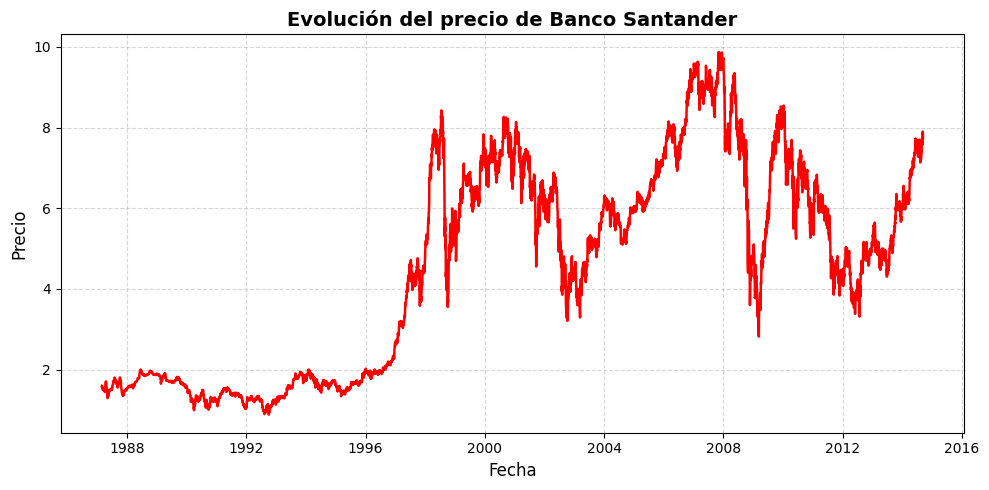

In [ ]:
plt.figure(figsize=(10,5))  # Tamaño del gráfico
plt.plot(santander, color='red', linewidth=1.8)

plt.title("Evolución del precio de Banco Santander", fontsize=14, fontweight='bold')
plt.xlabel("Fecha", fontsize=12)
plt.ylabel("Precio", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


In [ ]:
pvalue = adfuller(santander)[1]

if pvalue < 0.05: print("La serie santander es estacionaria")
else: print("La serie santander no es estacionaria")

La serie santander no es estacionaria


El precio no es estacionario en media ni en varianza, por lo que tomamos la primera diferencia del logaritmo; los rendimientos. Además, parece que el precio del activo sigue dos modelos diferentes bien diferenciados, por lo que tomaremos la muestra de datos a partir del 1998, considerando la segunda estructura. Esta muestra la seleccionaremos desde que la cotización del Santander alcanza un valor cercano a 5.

In [ ]:
# Observamos el primer índice del array para el cual
# el banco Santander supera este umbral

print(np.where((4.9<santander) & (santander<5.1))[0][0])

2827


In [ ]:
# Observamos número de observaciones en nuestra muestra

print(len(train_santander), len(santander))

4181 7182


Tomaremos como muestra desde el elemento 2827 hasta el final de esta, el elemento 4181 (recordamos que hemos eliminado 3000 observaciones, por lo que realmente la muestra completa tiene 7182 elementos).

Dado que los rendimientos se calculan a partir de los precios, el número de observaciones en rendimientos es uno menor que en precios. Por tanto, para que ambos conjuntos estén alineados correctamente, en la serie de rendimientos debemos comenzar en el elemento 2826 en lugar del 2827. Realizamos esta aclaración aunque, para el ajuste del modelo, no es realmente relevante si tomamos la muestra un día después o no.

In [ ]:
# Vemos que coinciden las fechas

print(santander.index[2827], r_santander.index[2826])


1997-12-31 00:00:00 1997-12-31 00:00:00


In [ ]:
# Muestra de rendimientos a ajustar

train_santander_cut = r_santander[2827:-N]

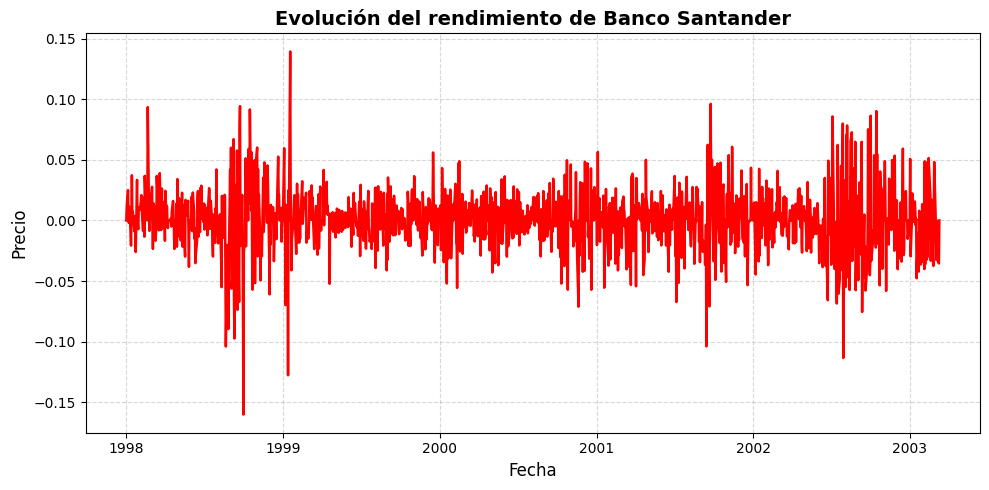

In [ ]:
plt.figure(figsize=(10,5))  # Tamaño del gráfico
plt.plot(train_santander_cut, color='red', linewidth=1.8)

plt.title("Evolución del rendimiento de Banco Santander", fontsize=14, fontweight='bold')
plt.xlabel("Fecha", fontsize=12)
plt.ylabel("Precio", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

Como vemos, al haber eliminado las $3000$ observaciones más recientes y un número elevado también de las primeras observaciones ya que parecían seguir otra estructura; añadido a que el Santander comenzó a cotizar tarde, nos hemos quedado con una muestra pequeña de tan solo 5 años. El eliminar tantas observaciones recientes tiene un motivo de peso para los demás activos, al utilizar el mismo $N$ para los tres, esta muestra se nos queda algo corta, hecho que hacemos notar en este comentario.

Retardos ACF significativos: (array([ 0,  3,  8, 15, 21, 29, 46]),)
Retardos PACF significativos: (array([ 0,  3,  8, 15, 21, 29, 40, 46]),)


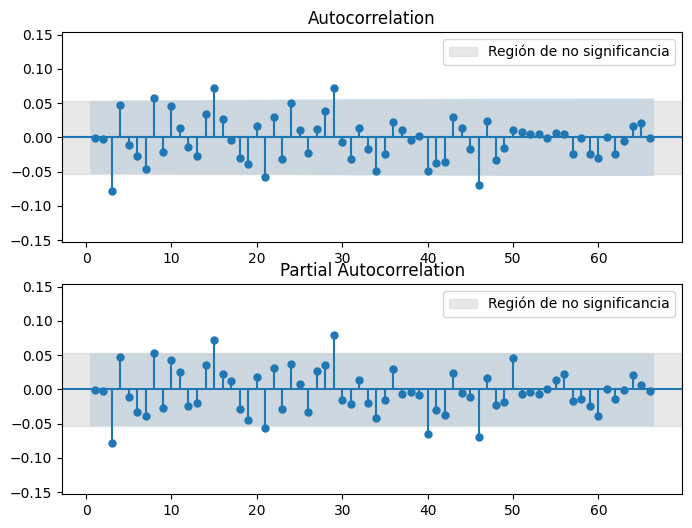

In [ ]:
acf_pacf(y=train_santander_cut, lags=66)

Estimamos un modelo AR con los retardos significativos ($3, 8, 15, 21, 29, 40$ y $46$ exclusivamente). Empleamos este modelo ya que es más propio utilizar un AR que un MA si la ACF y la PACF se parecen bastante, ya que cabe recordar que un AR finito es equivalente a un MA infinito. En el gráfico no hemos pintado la autocorrelación de orden 0 porque es igual a 1 arbitrariamente, así como tampoco lo consideramos como retardo significativo.

In [ ]:
# Estimación del modelo con los retardos significativos

p_max = 46
model = sm.tsa.SARIMAX(train_santander_cut,
                       order=(p_max, 0, 0),
                       trend='c',
                       enforce_stationarity=False,
                       enforce_invertibility=False)


allowed_ar = {'ar.L3', 'ar.L8', 'ar.L15', 'ar.L21', 'ar.L29', 'ar.L40', 'ar.L46'}

fix_params = {}
for name in model.param_names:
    if name.startswith('ar.'):
        if name not in allowed_ar:
            fix_params[name] = 0.0
# Fit with constraints (constrained MLE)
res = model.fit_constrained(fix_params, disp=False)

print(res.summary())

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1354
Model:              SARIMAX(46, 0, 0)   Log Likelihood                2931.810
Date:                Fri, 17 Oct 2025   AIC                          -5845.619
Time:                        17:51:28   BIC                          -5799.033
Sample:                    01-01-1998   HQIC                         -5828.145
                         - 03-11-2003                                         
Covariance Type:                  opg                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
intercept         -0.0005      0.001     -0.713      0.476      -0.002       0.001
ar.L1 (fixed)           0        nan        nan        nan         nan         nan
ar.L2 (fixed)           0        nan

Salvo el intercepto, todos los coeficientes son significativos. Ahora comprobaremos de nuevo los residuos de este modelo a ver si es necesario añadir algún coeficiente o podemos eliminar alguno.

Retardos ACF significativos: (array([0]),)
Retardos PACF significativos: (array([ 0, 10]),)


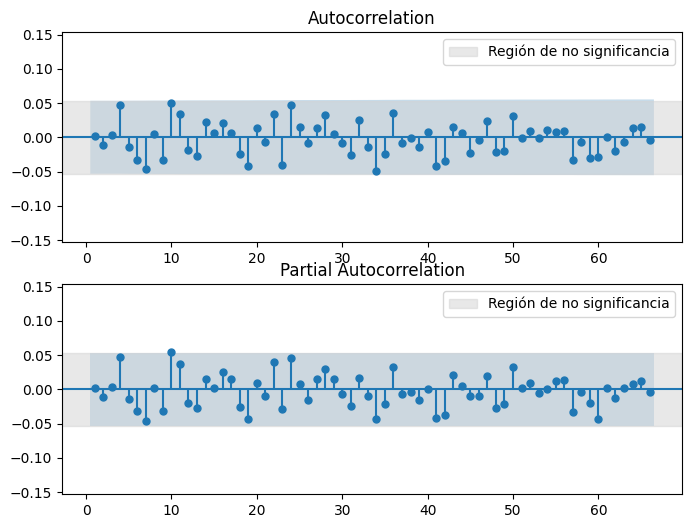

In [ ]:
residuals = res.resid

acf_pacf(y=residuals, lags=66)

Vemos que falta un retardo significativo todavía (el retardo $10$), así que lo incluiremos en el modelo.

In [ ]:
# Ajuste del modelo añadiendo el retardo

allowed_ar = {'ar.L3', 'ar.L8', 'ar.L10', 'ar.L15', 'ar.L21', 'ar.L29', 'ar.L40', 'ar.L46'}

fix_params = {}
for name in model.param_names:
    if name.startswith('ar.'):
        if name not in allowed_ar:
            fix_params[name] = 0.0
# Fit with constraints (constrained MLE)
res = model.fit_constrained(fix_params, disp=False)

print(res.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1354
Model:              SARIMAX(46, 0, 0)   Log Likelihood                2933.436
Date:                Fri, 17 Oct 2025   AIC                          -5846.873
Time:                        17:51:50   BIC                          -5795.110
Sample:                    01-01-1998   HQIC                         -5827.457
                         - 03-11-2003                                         
Covariance Type:                  opg                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
intercept         -0.0005      0.001     -0.682      0.495      -0.002       0.001
ar.L1 (fixed)           0        nan        nan        nan         nan         nan
ar.L2 (fixed)           0        nan

De nuevo, todo los retardos son significativos y el modelo parece que explica bien los rendimientos. El intercepto nunca ha sido significativo por lo que no lo consideramos.

Retardos ACF significativos: (array([0]),)
Retardos PACF significativos: (array([0]),)


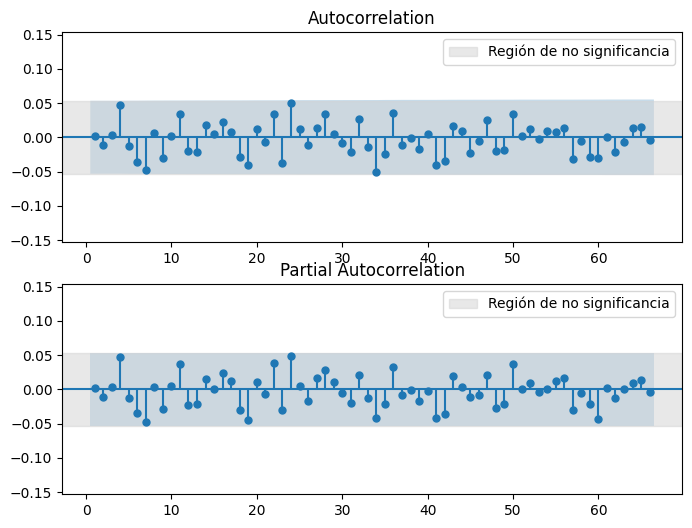

In [ ]:
residuals = res.resid

acf_pacf(y=residuals, lags=66)

No falta por añadir al modelo ningún retardo significativo, por lo que nos quedamos con este modelo como el óptimo, ya que los residuos no presentan autocorrelaciones significativas y los podemos considerar ruido blanco. Denotemos $S_t$ al precio de la acción del Santander en el momento $t$:

$$
r_t = \nabla\log(S_t),\\
r_t = \phi_3 r_{t-3} + \phi_8 r_{t-8} + \phi_{10} r_{t-10} + \phi_{15} r_{t-15} + \phi_{21} r_{t-21} + \phi_{29} r_{t-29} + \phi_{40} r_{t-40} + + \phi_{46} r_{t-46},
$$
donde las estimaciones de estos parámetros en este modelo son:

$$
\hat{\phi}_{3} = -0.0765 \\
\hat{\phi}_{8} = 0.0608 \\
\hat{\phi}_{10} = 0.0494 \\
\hat{\phi}_{15} = 0.0679 \\
\hat{\phi}_{21} = -0.0638 \\
\hat{\phi}_{29} = 0.0805 \\
\hat{\phi}_{40} = -0.0573 \\
\hat{\phi}_{46} = -0.0694 \\
$$

**Predicción para los rendimientos**




Para ver qué tal funcionaba nuestro modelo, lo pusimos a prueba con el conjunto de datos de test, que eran datos que no había visto nunca.

Primero, le pedimos al modelo que hiciera una predicción para todo ese período. Luego, para saber si había acertado, calculamos el error que cometía con el RMSE y el MAE, que básicamente nos dicen, en promedio, por cuánto se equivocó el modelo en sus predicciones.

Al final, hicimos un gráfico para verlo todo más claro: pusimos los datos reales de prueba en negro y nuestras predicciones en rojo. Esto nos sirvió para comparar a simple vista si la línea roja de nuestras predicciones seguía bien a la línea negra de la realidad.

=== Predicciones del modelo SARIMAX ===
2003-03-12   -0.001525
2003-03-13    0.001178
2003-03-14    0.005104
2003-03-17   -0.009089
2003-03-18   -0.003738
                ...   
2014-09-03   -0.000512
2014-09-04   -0.000512
2014-09-05   -0.000512
2014-09-08   -0.000512
2014-09-09   -0.000512
Freq: B, Name: predicted_mean, Length: 3000, dtype: float64

=== Intervalos de confianza ===
             lower y   upper y
2003-03-12 -0.051876  0.048825
2003-03-13 -0.049172  0.051528
2003-03-14 -0.045247  0.055454
2003-03-17 -0.059586  0.041409
2003-03-18 -0.054235  0.046760
...              ...       ...
2014-09-03 -0.051780  0.050755
2014-09-04 -0.051780  0.050755
2014-09-05 -0.051780  0.050755
2014-09-08 -0.051780  0.050755
2014-09-09 -0.051780  0.050755

[3000 rows x 2 columns]
MAE sobre el conjunto de prueba: 0.0140

RMSE sobre el conjunto de prueba: 0.0208
 Versión porcentual
MAE sobre el conjunto de prueba: 184.90%

RMSE sobre el conjunto de prueba:inf%


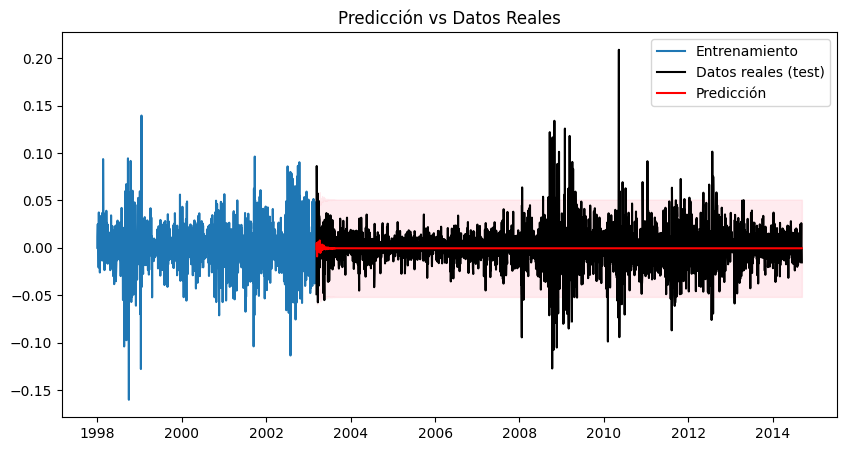

In [ ]:
# Predicciones para el Banco Santander

pred(y_test=test_santander, y_train=train_santander_cut, modelo=res)

El modelo muestra un alto rendimiento predictivo. El error promedio (MAE) es de $0.0140$, mientras que el RMSE es de $0.0208$. Los valores porcentuales para los rendimientos no los hemos de tener en cuenta ya que en media son estadísticamente igual a $0$, por lo tanto al dividir entre estos se van a ir a valores enormes ($\infty$).

Ambos valores son bajos, y la pequeña diferencia entre ellos sugiere que las predicciones son consistentes y no presentan grandes errores atípicos.

Si miramos al gráfico podemos ver que nuestro modelo acierta en predecir que el rendimiento promedio es cero, pero falla en en que ignora por completo la volatilidad.

Asume que el riesgo y las fluctuaciones diarias son siempre constantes, cuando el gráfico demuestra que eso no es así. Como resultado, el modelo subestima masivamente el riesgo real, lo que lo hace inútil para aplicaciones prácticas y demuestra la necesidad de usar un modelo más avanzado como GARCH.

**Predicción para los precios**




Ahora vamos a aplicar la misma estructura del modelo que usamos para los rendimientos directamente a la serie de precios del activo.

El objetivo es observar  las diferencias en el rendimiento y la significancia de los parámetros cuando el modelo se enfrenta a una serie no estacionaria (precios) en contraste con una estacionaria (rendimientos). Esto nos permitirá ver la importancia de tratar de los datos.

Volvemos a coger el mismo periodo de tiempo que con los rendimientos para estimar el modelo.

In [ ]:
# Elegimos el mismo periodo para estimar el modelo

train_p_santander_cut = santander[2827:-N]

In [ ]:
p_max = 46
model = sm.tsa.SARIMAX(train_p_santander_cut,
                       order=(p_max, 0, 0),
                       trend='c',
                       enforce_stationarity=False,
                       enforce_invertibility=False)

allowed_ar = {'ar.L3', 'ar.L8', 'ar.L10', 'ar.L15', 'ar.L21', 'ar.L29', 'ar.L40', 'ar.L46'}

fix_params = {}
for name in model.param_names:
    if name.startswith('ar.'):
        if name not in allowed_ar:
            fix_params[name] = 0.0
# Fit with constraints (constrained MLE)
res = model.fit_constrained(fix_params, disp=False)

print(res.summary())

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                               SARIMAX Results                                
Dep. Variable:        BANCO SANTANDER   No. Observations:                 1355
Model:              SARIMAX(46, 0, 0)   Log Likelihood                 -52.526
Date:                Fri, 17 Oct 2025   AIC                            125.052
Time:                        17:52:43   BIC                            176.823
Sample:                    12-31-1997   HQIC                           144.470
                         - 03-11-2003                                         
Covariance Type:                  opg                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
intercept          0.1027      0.046      2.243      0.025       0.013       0.192
ar.L1 (fixed)           0        nan        nan        nan         nan         nan
ar.L2 (fixed)           0        nan

Al probar el mismo modelo con los precios en vez de con los rendimientos, nos dimos cuenta de que varios de los retardos que antes eran significativos (el $8, 10, 15, 21$ y $29$) de repente dejaron de ser significativos.

Esto pasó porque los precios y los rendimientos son dos series temporales bastante distintas. Los rendimientos son más o menos estables y se mueven alrededor de cero, así que es más fácil ver los patrones. Pero los precios tienen una tendencia muy fuerte a subir o a bajar.

Esa tendencia tan fuerte en los precios es como un "ruido" muy alto que no deja ver los patrones más pequeños que nuestro modelo había encontrado antes en los rendimientos. Básicamente, el modelo no es capaz de interpretar la tendencia y por eso esos retardos ya no le parecen importantes.

Retardos ACF significativos: (array([ 0,  1,  2,  4, 37, 38, 43, 46]),)
Retardos PACF significativos: (array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 19, 22, 25, 28, 41, 44]),)


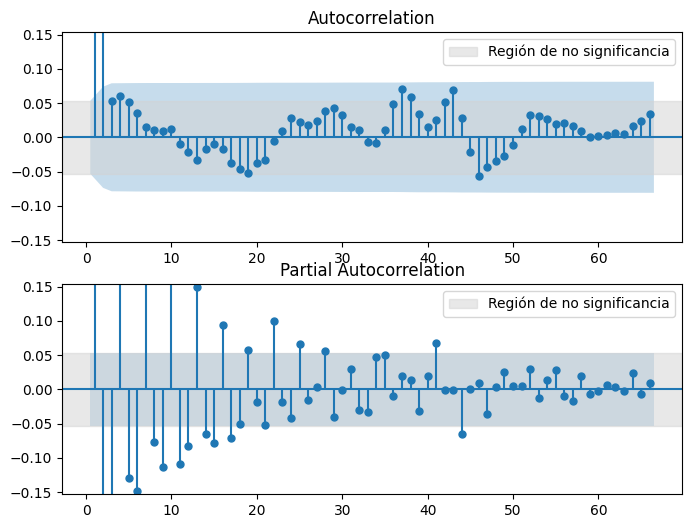

In [ ]:
residuals = res.resid

acf_pacf(y=residuals, lags=66)

Como era de esperar, no es un buen modelo para los precios y la serie de residuos no se asemeja para nada a un ruido blanco.

**Predicción de los precios**

Ahora vamos a evaluar la capacidad predictiva del modelo sobre el conjunto de prueba. Generamos un pronóstico para este período y medimos su precisión comparando los valores predichos con los precios reales.

Para la evaluación cuantitativa, inicialmente calculamos métricas de error estándar como el Error Absoluto Medio (MAE) y la Raíz del Error Cuadrático Medio (RMSE). Sin embargo, dado que estamos pronosticando precios (una variable no estacionaria que no oscila en torno a cero), complementamos nuestro análisis con sus versiones porcentuales. Estas métricas son más adecuadas en este contexto, ya que expresan el error en una escala relativa, facilitando así la interpretación de la magnitud del error de pronóstico.

Finalmente, realizamos una evaluación visual mediante un gráfico que superpone los precios reales, nuestras predicciones y los intervalos de confianza, permitiendo una comprobación cualitativa del rendimiento del modelo.

=== Predicciones del modelo SARIMAX ===
2003-03-12    3.617332
2003-03-13    3.518743
2003-03-14    3.534358
2003-03-17    3.682257
2003-03-18    3.585371
                ...   
2014-09-03    5.900801
2014-09-04    5.900801
2014-09-05    5.900801
2014-09-08    5.900801
2014-09-09    5.900801
Freq: B, Name: predicted_mean, Length: 3000, dtype: float64

=== Intervalos de confianza ===
            lower BANCO SANTANDER  upper BANCO SANTANDER
2003-03-12               3.123224               4.111440
2003-03-13               3.024635               4.012851
2003-03-14               3.040250               4.028466
2003-03-17               3.010868               4.353646
2003-03-18               2.913982               4.256760
...                           ...                    ...
2014-09-03               4.144517               7.657085
2014-09-04               4.144517               7.657085
2014-09-05               4.144517               7.657085
2014-09-08               4.144517           

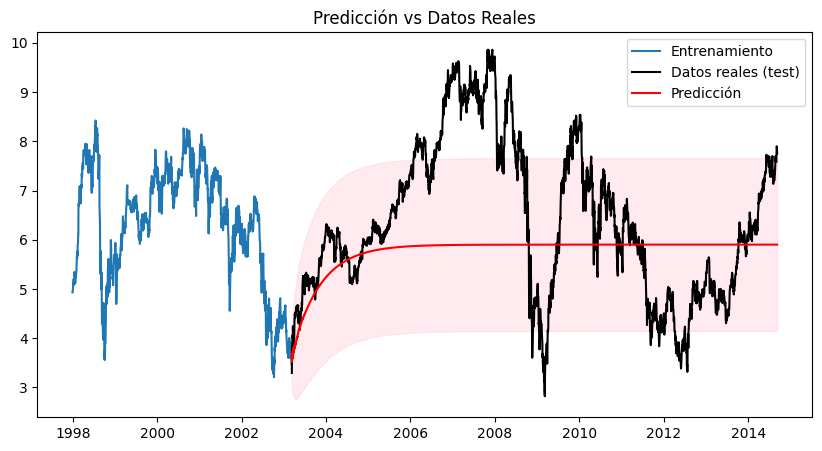

In [ ]:
pred(y_test=test_p_santander, y_train=train_p_santander_cut, modelo=res)

El análisis de los resultados revela un rendimiento deficiente del modelo de pronóstico.

El gráfico muestra que la predicción (línea roja) adopta una forma prácticamente lineal y estática, demostrando una clara incapacidad para capturar la volatilidad, los ciclos y las tendencias presentes en los datos reales del conjunto de prueba (línea negra) como ya hemos argumentado con la serie de los rendimientos.

Esta observación es corroborada por las métricas cuantitativas. Un RMSE del 19.99% y un MAE del 20.56% son indicadores de un error significativamente alto, confirmando que las predicciones se desvían considerablemente de los valores observados.

En conclusión, el modelo en su estado actual no es un instrumento fiable para el pronóstico de esta serie temporal, ya que no logra capturar los patrones que modelan su comportamiento.

**T-Bills a 3 meses de EE.UU.**


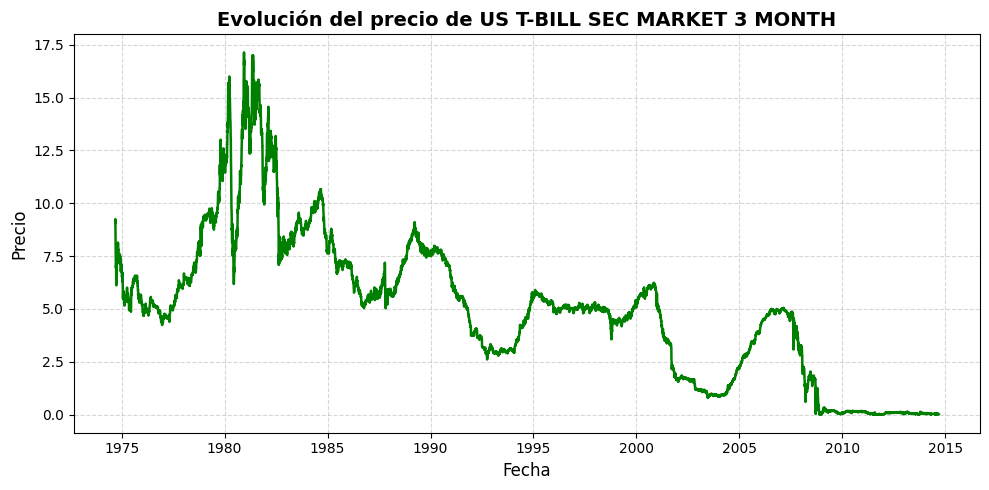

In [ ]:
plt.figure(figsize=(10,5))  # Tamaño del gráfico
plt.plot(us_3month, color='green', linewidth=1.8)

plt.title("Evolución del precio de US T-BILL SEC MARKET 3 MONTH", fontsize=14, fontweight='bold')
plt.xlabel("Fecha", fontsize=12)
plt.ylabel("Precio", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

In [ ]:
pvalue = adfuller(us_3month)[1]

if pvalue < 0.05: print("La serie us_3month es estacionaria")
else: print("La serie us_3month no es estacionaria")

La serie us_3month no es estacionaria


Esta serie no es estacionaria ni en media ni en varianza. Como sucedía con el Banco Santander, parece que hay dos estructuras claramente diferenciadas de la evolución del activo, así que, como hacíamos con el primero, tomaremos la muestra desde 1988.

In [ ]:
target_date = pd.to_datetime("1988-01-01")
idx = us_3month.index.get_loc(target_date)
print(idx)

3474


In [ ]:
len(us_3month)

10437

Tomamos como muestra desde el elemento $3474$ hasta el $10337$ (recordemos que se eliminaron las últimas $100$ observaciones, por lo que la muestra total contiene $10437$ observaciones).

Dado que los rendimientos se calculan a partir de los precios, el número de observaciones en rendimientos es una unidad menor que en precios. Por tanto, para mantener la correcta correspondencia entre ambas series, en la serie de rendimientos debemos comenzar en el elemento $3473$ en lugar del $3474$.

In [ ]:
train_us_3month_cut = r_us_3month[3473:-N]

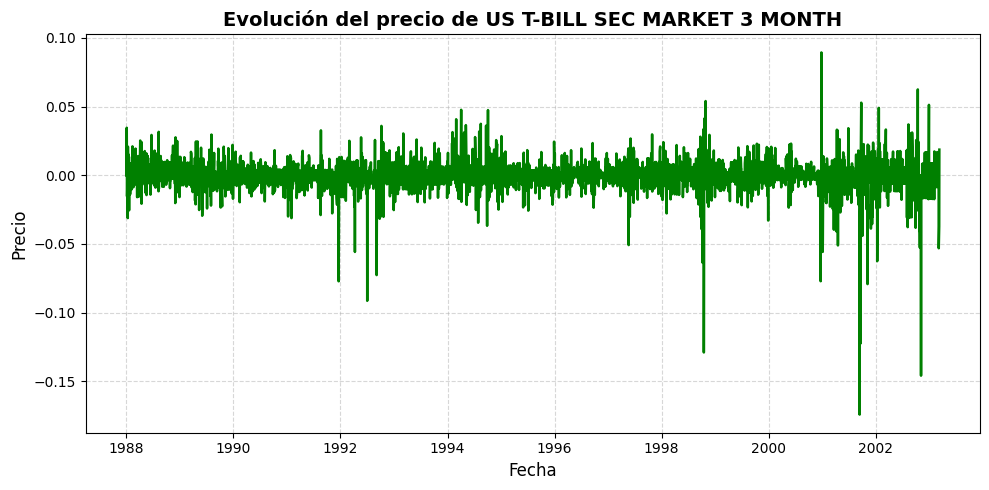

In [ ]:
plt.figure(figsize=(10,5))  # Tamaño del gráfico
plt.plot(train_us_3month_cut, color='green', linewidth=1.8)

plt.title("Evolución del precio de US T-BILL SEC MARKET 3 MONTH", fontsize=14, fontweight='bold')
plt.xlabel("Fecha", fontsize=12)
plt.ylabel("Precio", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

In [ ]:
pvalue = adfuller(train_us_3month_cut)[1]

if pvalue < 0.05: print("La serie train_us_3month_cut es estacionaria")
else: print("La serie train_us_3month_cut no es estacionaria")

La serie train_us_3month_cut es estacionaria


Esta serie es estacionaria en media. Utilizando la misma manera de proceder que para el banco Santander, observaremos la ACF y la PACF con $66$ retardos para ajustar un modelo apropiado para estos datos.


Retardos ACF significativos: (array([ 0,  1,  4,  7,  8,  9, 10, 15, 19, 20, 25, 35, 40, 50, 54, 60, 62,
       64, 65]),)
Retardos PACF significativos: (array([ 0,  1,  4,  7,  8,  9, 10, 15, 16, 20, 25, 50, 60, 62, 65]),)


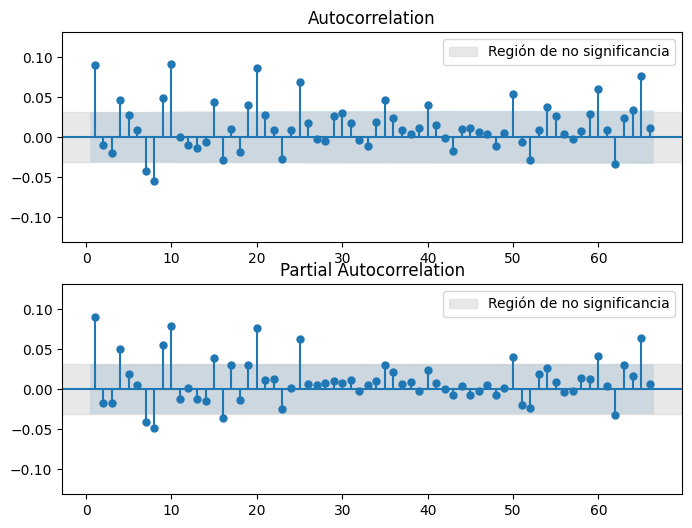

In [ ]:
acf_pacf(y=train_us_3month_cut, lags=66)

Como hay bastantes retardos significativos, propondremos un primer modelo empleando los retardos comunes a la ACF y a la PACF y veremos cómo se comporta.

In [ ]:
p_max = 65
model = sm.tsa.SARIMAX(train_us_3month_cut,
                       order=(p_max, 0, 0),
                       trend='c',
                       enforce_stationarity=False,
                       enforce_invertibility=False)


allowed_ar = {'ar.L1', 'ar.L4', 'ar.L7', 'ar.L8', 'ar.L9', 'ar.L10', 'ar.L15', 'ar.L20', 'ar.L25', 'ar.L50', 'ar.L60', 'ar.L62', 'ar.L65'}

fix_params = {}
for name in model.param_names:
    if name.startswith('ar.'):
        if name not in allowed_ar:
            fix_params[name] = 0.0
# Fit with constraints (constrained MLE)
res = model.fit_constrained(fix_params, disp=False)

print(res.summary())

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 3963
Model:              SARIMAX(65, 0, 0)   Log Likelihood               12081.159
Date:                Fri, 17 Oct 2025   AIC                         -24132.317
Time:                        17:55:03   BIC                         -24038.294
Sample:                    01-01-1988   HQIC                        -24098.945
                         - 03-11-2003                                         
Covariance Type:                  opg                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
intercept         -0.0003      0.000     -1.249      0.212      -0.001       0.000
ar.L1              0.0899      0.010      8.956      0.000       0.070       0.110
ar.L2 (fixed)           0        nan

Salvo el retardo $15$, todos los retardos son significativos, por lo que deberíamos eliminar este retardo. Cabe destacar que el intercepto es no significativo, de nuevo. Antes de ver la estructura de los residuos para ver qué retardos podríamos añadir, vamos a eliminar el retardo no significativo para ver si en el modelo más simplificado son todos los retardos significativos y así comenzar a añadir los retardos pertinentes a partir de este.

In [ ]:
allowed_ar = {'ar.L1', 'ar.L4', 'ar.L7', 'ar.L8', 'ar.L9', 'ar.L10', 'ar.L20', 'ar.L25', 'ar.L50', 'ar.L60', 'ar.L62', 'ar.L65'}

fix_params = {}
for name in model.param_names:
    if name.startswith('ar.'):
        if name not in allowed_ar:
            fix_params[name] = 0.0
# Fit with constraints (constrained MLE)
res = model.fit_constrained(fix_params, disp=False)

print(res.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 3963
Model:              SARIMAX(65, 0, 0)   Log Likelihood               12079.943
Date:                Fri, 17 Oct 2025   AIC                         -24131.886
Time:                        17:57:49   BIC                         -24044.131
Sample:                    01-01-1988   HQIC                        -24100.739
                         - 03-11-2003                                         
Covariance Type:                  opg                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
intercept         -0.0003      0.000     -1.313      0.189      -0.001       0.000
ar.L1              0.0899      0.010      8.915      0.000       0.070       0.110
ar.L2 (fixed)           0        nan

Eliminando el retardo $15$, obtenemos todos los coeficientes significativos. Veamos cómo se comportan las estructuras de autocorrelación de los residuos.

Retardos ACF significativos: (array([ 0, 16, 63]),)
Retardos PACF significativos: (array([ 0, 16, 63]),)


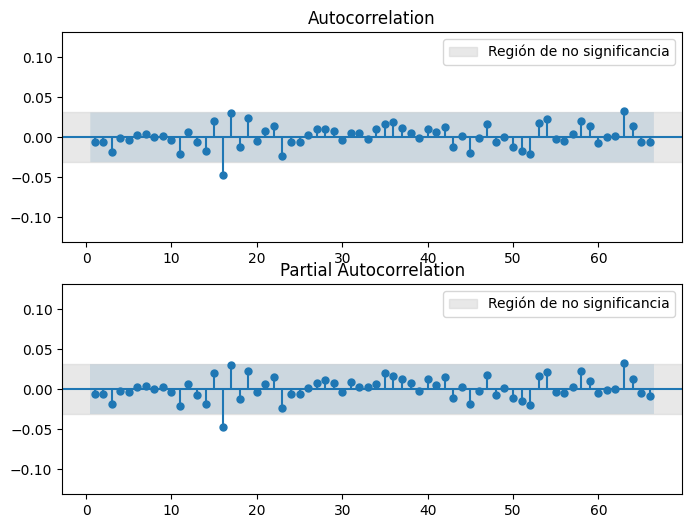

In [ ]:
residuals = res.resid

acf_pacf(y=residuals, lags=66)

Estimemos ahora un modelo añadiendo los retardos $16$ y $63$.

In [ ]:
allowed_ar = {'ar.L1', 'ar.L4', 'ar.L7', 'ar.L8', 'ar.L9', 'ar.L10', 'ar.L16', 'ar.L20', 'ar.L25', 'ar.L50', 'ar.L60', 'ar.L62', 'ar.L63', 'ar.L65'}

fix_params = {}
for name in model.param_names:
    if name.startswith('ar.'):
        if name not in allowed_ar:
            fix_params[name] = 0.0
# Fit with constraints (constrained MLE)
res = model.fit_constrained(fix_params, disp=False)

print(res.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 3963
Model:              SARIMAX(65, 0, 0)   Log Likelihood               12085.054
Date:                Fri, 17 Oct 2025   AIC                         -24138.108
Time:                        18:00:52   BIC                         -24037.817
Sample:                    01-01-1988   HQIC                        -24102.511
                         - 03-11-2003                                         
Covariance Type:                  opg                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
intercept         -0.0003      0.000     -1.356      0.175      -0.001       0.000
ar.L1              0.0899      0.010      8.909      0.000       0.070       0.110
ar.L2 (fixed)           0        nan

Salvo el retardo $63$, todos los retardos son significativos, así que haremos un modelo eliminando este retardo y veamos a posteriori la estructura de autocorrelación de los residuos.

In [ ]:
allowed_ar = {'ar.L1', 'ar.L4', 'ar.L7', 'ar.L8', 'ar.L9', 'ar.L10', 'ar.L16', 'ar.L20', 'ar.L25', 'ar.L50', 'ar.L60', 'ar.L62', 'ar.L65'}

fix_params = {}
for name in model.param_names:
    if name.startswith('ar.'):
        if name not in allowed_ar:
            fix_params[name] = 0.0
# Fit with constraints (constrained MLE)
res = model.fit_constrained(fix_params, disp=False)

print(res.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 3963
Model:              SARIMAX(65, 0, 0)   Log Likelihood               12082.940
Date:                Fri, 17 Oct 2025   AIC                         -24135.881
Time:                        18:03:32   BIC                         -24041.857
Sample:                    01-01-1988   HQIC                        -24102.508
                         - 03-11-2003                                         
Covariance Type:                  opg                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
intercept         -0.0003      0.000     -1.421      0.155      -0.001       0.000
ar.L1              0.0899      0.010      8.902      0.000       0.070       0.110
ar.L2 (fixed)           0        nan

Como era de esperar, todos los retardos son significativos, comprobemos ahora la estructura de autocorrelación de los residuos.

Retardos ACF significativos: (array([ 0, 17, 63]),)
Retardos PACF significativos: (array([ 0, 17, 63]),)


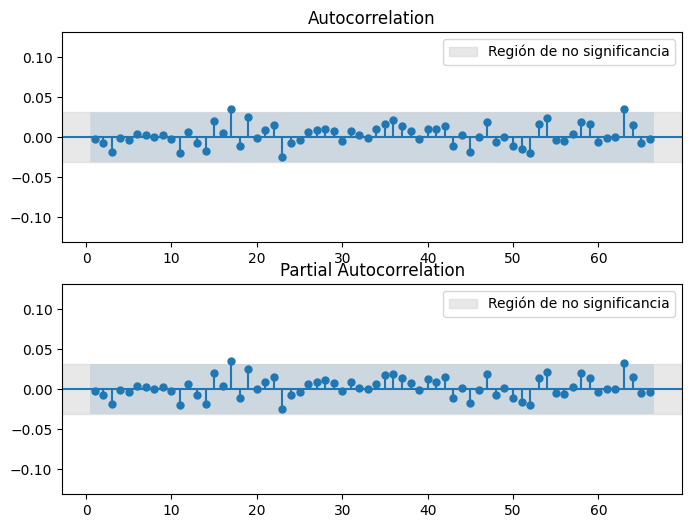

In [ ]:
residuals = res.resid

acf_pacf(y=residuals, lags=66)

Parece que hay que añadir el retardo $63$ a la vez que el retardo $17$, incluiremos ambos y esperemos que este modelo sea el definitivo.

In [ ]:
allowed_ar = {'ar.L1', 'ar.L4', 'ar.L7', 'ar.L8', 'ar.L9', 'ar.L10', 'ar.L16', 'ar.L17', 'ar.L20', 'ar.L25', 'ar.L50', 'ar.L60', 'ar.L62', 'ar.L63', 'ar.L65'}

fix_params = {}
for name in model.param_names:
    if name.startswith('ar.'):
        if name not in allowed_ar:
            fix_params[name] = 0.0
# Fit with constraints (constrained MLE)
res = model.fit_constrained(fix_params, disp=False)

print(res.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 3963
Model:              SARIMAX(65, 0, 0)   Log Likelihood               12088.249
Date:                Fri, 17 Oct 2025   AIC                         -24142.498
Time:                        18:07:08   BIC                         -24035.938
Sample:                    01-01-1988   HQIC                        -24104.676
                         - 03-11-2003                                         
Covariance Type:                  opg                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
intercept         -0.0003      0.000     -1.262      0.207      -0.001       0.000
ar.L1              0.0899      0.010      8.965      0.000       0.070       0.110
ar.L2 (fixed)           0        nan

De nuevo, todos los retardos son significativos salvo el $63$, parece que nos da ciertos problemas.

Retardos ACF significativos: (array([0]),)
Retardos PACF significativos: (array([0]),)


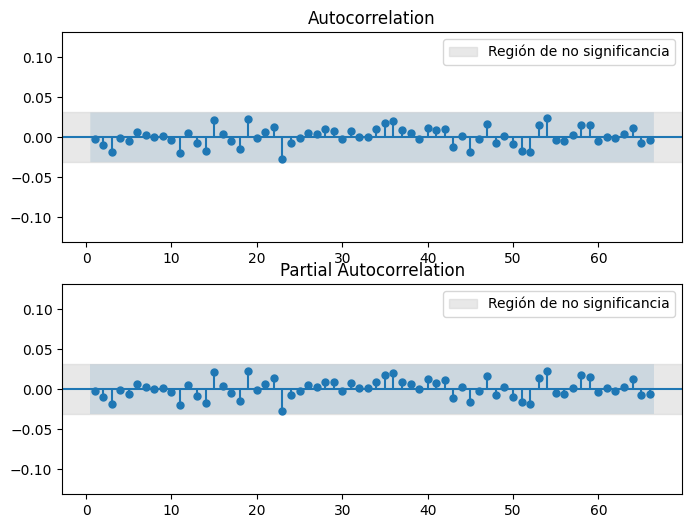

In [ ]:
residuals = res.resid

acf_pacf(y=residuals, lags=66)

A pesar de que el retardo $63$ sea no significativo (tiene valor  $0.08>0.05$ ), los residuos no presentan ninguna estructura de autocorrelación, que es el objetivo final al tratar de elegir el modelo óptimo. Veamos si eliminando el retardo $63$ no significativo y conservando los demás esto sigue sucediendo.

In [ ]:
allowed_ar = {'ar.L1', 'ar.L4', 'ar.L7', 'ar.L8', 'ar.L9', 'ar.L10', 'ar.L16', 'ar.L17', 'ar.L20', 'ar.L25', 'ar.L50', 'ar.L60', 'ar.L62', 'ar.L65'}

fix_params = {}
for name in model.param_names:
    if name.startswith('ar.'):
        if name not in allowed_ar:
            fix_params[name] = 0.0
# Fit with constraints (constrained MLE)
res = model.fit_constrained(fix_params, disp=False)

print(res.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 3963
Model:              SARIMAX(65, 0, 0)   Log Likelihood               12086.168
Date:                Fri, 17 Oct 2025   AIC                         -24140.336
Time:                        18:09:43   BIC                         -24040.044
Sample:                    01-01-1988   HQIC                        -24104.738
                         - 03-11-2003                                         
Covariance Type:                  opg                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
intercept         -0.0003      0.000     -1.326      0.185      -0.001       0.000
ar.L1              0.0899      0.010      8.955      0.000       0.070       0.110
ar.L2 (fixed)           0        nan

Retardos ACF significativos: (array([ 0, 63]),)
Retardos PACF significativos: (array([ 0, 63]),)


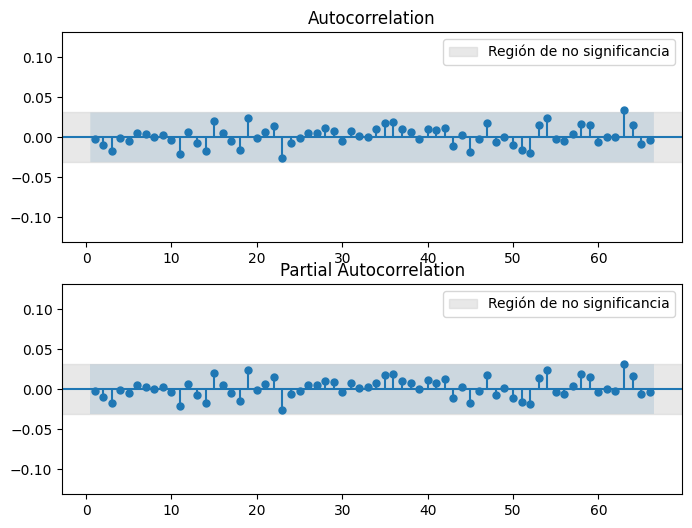

In [ ]:
residuals = res.resid

acf_pacf(y=residuals, lags=66)

In [ ]:
acf_vals = acf(train_us_3month_cut, nlags=66)
pacf_vals = pacf(train_us_3month_cut, nlags=66)

In [ ]:
print(acf_vals[63])

0.023867408982948122


In [ ]:
print(pacf_vals[63])

0.030653188401232597


In [ ]:
valor_critico = 1.96 / np.sqrt(len(residuals))

print(valor_critico)

0.031134653385468378


Como vemos, parece que la estructura de autocorrelación de los residuos nos indica que habría que incluir el retardo $63$, aunque está en el borde del valor crítico para el que deberíamos incluirlo o no. Comparando el resultado entre el modelo incluyendo el retardo $63$ (no significativo) y el modelo descartando al retardo $63$ (significativo en las estructuras de autocorrelación por poco), vamos a elegir como modelo óptimo el modelo sin el retardo $63$, ya que son preferible modelos más simples frente a modelos con demasiados parámetros, el retardo 63 no estaba en la estructura de autocorrelación en la serie principal de los rendimientos y la diferencia con respecto al valor crítico para considerarlo relevante que su residuo sea significativo no parece demasiado grande.

Teniendo esto en cuenta, nuestro modelo óptimo es el siguiente. Denotemos $B_t$ al tipo de interés del dólar en el momento $t$:

$$
r_t = \nabla\log(B_t),\\
r_t = \phi_1 r_{t-1} + \phi_4 r_{t-4} + \phi_{7} r_{t-7} + \phi_{8} r_{t-8} + \phi_{9} r_{t-9} + \phi_{10} r_{t-10} + \phi_{16} r_{t-16} + \phi_{17} r_{t-17} + \phi_{20} r_{t-20} + \phi_{25} r_{t-25} + \phi_{50} r_{t-50} + \phi_{60} r_{t-60} + \phi_{62} r_{t-62} + \phi_{65} r_{t-65},
$$
donde las estimaciones de estos parámetros en este modelo son:

$$
\hat{\phi}_{1} = 0.0899 \\
\hat{\phi}_{4} = 0.0512 \\
\hat{\phi}_{7} = -0.0375 \\
\hat{\phi}_{8} = -0.0556 \\
\hat{\phi}_{9} = 0.0499 \\
\hat{\phi}_{10} = 0.0641 \\
\hat{\phi}_{16} = -0.0526 \\
\hat{\phi}_{17} = 0.0396 \\
\hat{\phi}_{20} = 0.0741 \\
\hat{\phi}_{25} = 0.0553 \\
\hat{\phi}_{50} = 0.0394 \\
\hat{\phi}_{60} = 0.0403 \\
\hat{\phi}_{62} = -0.0353 \\
\hat{\phi}_{65} = 0.0653 \\
$$

**Predicción de los rendimientos**

Tal y como hicimos para el Banco Santander, pusimos a prueba nuestro modelo con los datos del tesoro estadounidense que no había visto nunca para comprobar su eficacia.

Primero, le pedimos que realizara un pronóstico para todo el periodo de test. A continuación, para medir su precisión, calculamos el error que cometía con las métricas RMSE y MAE, que nos indican cuánto se equivocó de media en sus predicciones.

Finalmente, creamos un gráfico para poder hacer una comparación visual directa y comprobar si nuestro pronóstico lograba seguir la tendencia de los datos reales.

=== Predicciones del modelo SARIMAX ===
2003-03-12    0.002012
2003-03-13   -0.002939
2003-03-14   -0.002029
2003-03-17    0.000979
2003-03-18   -0.000040
                ...   
2014-09-03   -0.000437
2014-09-04   -0.000437
2014-09-05   -0.000437
2014-09-08   -0.000437
2014-09-09   -0.000437
Freq: B, Name: predicted_mean, Length: 3000, dtype: float64

=== Intervalos de confianza ===
             lower y   upper y
2003-03-12 -0.019333  0.023357
2003-03-13 -0.024371  0.018492
2003-03-14 -0.023461  0.019403
2003-03-17 -0.020453  0.022411
2003-03-18 -0.021500  0.021419
...              ...       ...
2014-09-03 -0.022282  0.021407
2014-09-04 -0.022282  0.021407
2014-09-05 -0.022282  0.021407
2014-09-08 -0.022282  0.021407
2014-09-09 -0.022282  0.021407

[3000 rows x 2 columns]
MAE sobre el conjunto de prueba: inf

RMSE sobre el conjunto de prueba: inf
 Versión porcentual
MAE sobre el conjunto de prueba: 194.74%

RMSE sobre el conjunto de prueba:inf%


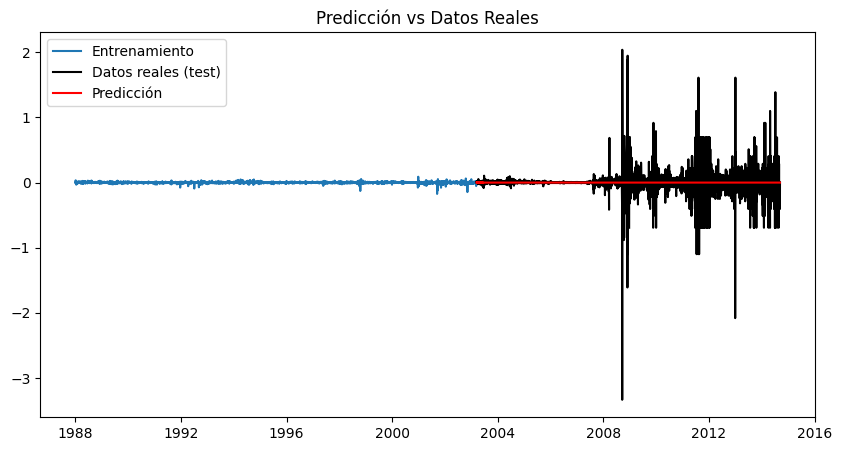

In [ ]:
pred(y_test=test_us_3month, y_train=train_us_3month_cut, modelo=res)

Al poner a prueba nuestro modelo, observamos un fallo total en su capacidad predictiva. La gráfica evidencia que la predicción se mantiene plana, incapaz de replicar la extrema volatilidad que caracteriza al periodo de prueba, coincidente con la crisis financiera de $2008$.

Este comportamiento se debe a que entrenamos el modelo con datos de un largo periodo de estabilidad, por lo que no pudo anticipar un evento de tal magnitud. Como consecuencia, los errores entre la predicción y los datos reales fueron tan grandes que las métricas RMSE y MAE arrojaron un valor infinito, confirmando que la volatilidad de la crisis era un fenómeno impredecible con la información histórica que teníamos.

**Predicción de los rendimientos**

Al igual que hicimos con las acciones del Banco Santander, ahora aplicaremos la misma estructura del modelo directamente a la serie de precios del activo, en lugar de a sus rendimientos.

Volvemos a coger el mismo periodo de tiempo que con los rndimientos.

In [ ]:
train_p_us_3month_cut = us_3month[3474:-N]

In [ ]:
p_max = 65
model = sm.tsa.SARIMAX(train_p_us_3month_cut,
                       order=(p_max, 0, 0),
                       trend='c',
                       enforce_stationarity=False,
                       enforce_invertibility=False)

allowed_ar = {'ar.L1', 'ar.L4', 'ar.L7', 'ar.L8', 'ar.L9', 'ar.L10', 'ar.L16', 'ar.L17', 'ar.L20', 'ar.L25', 'ar.L50', 'ar.L60', 'ar.L62', 'ar.L65'}

fix_params = {}
for name in model.param_names:
    if name.startswith('ar.'):
        if name not in allowed_ar:
            fix_params[name] = 0.0
# Fit with constraints (constrained MLE)
res = model.fit_constrained(fix_params, disp=False)

print(res.summary())

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                                    SARIMAX Results                                     
Dep. Variable:     US T-BILL SEC MARKET 3 MONTH   No. Observations:                 3963
Model:                        SARIMAX(65, 0, 0)   Log Likelihood                6354.108
Date:                          Fri, 17 Oct 2025   AIC                         -12676.216
Time:                                  18:18:53   BIC                         -12575.924
Sample:                              01-01-1988   HQIC                        -12640.619
                                   - 03-11-2003                                         
Covariance Type:                            opg                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
intercept          0.0020      0.003      0.705      0.481      -0.004       0.008
ar.L1              1.0035      0.006   

Al usar los precios directamente en el modelo, notamos que los retardos $4, 10, 20, 25, 50, 60, 62$ y $65$ perdieron su significancia estadística.

Esto sucede porque la tendencia de los precios actúa como una señal tan dominante que oculta los patrones más sutiles. El modelo se "distrae" con la tendencia general y ya no puede detectar las relaciones más débiles que sí eran visibles en los rendimientos, que son una serie estacionaria.

Retardos ACF significativos: (array([ 0,  1,  7,  8,  9, 13, 16]),)
Retardos PACF significativos: (array([ 0,  1,  7,  8, 13]),)


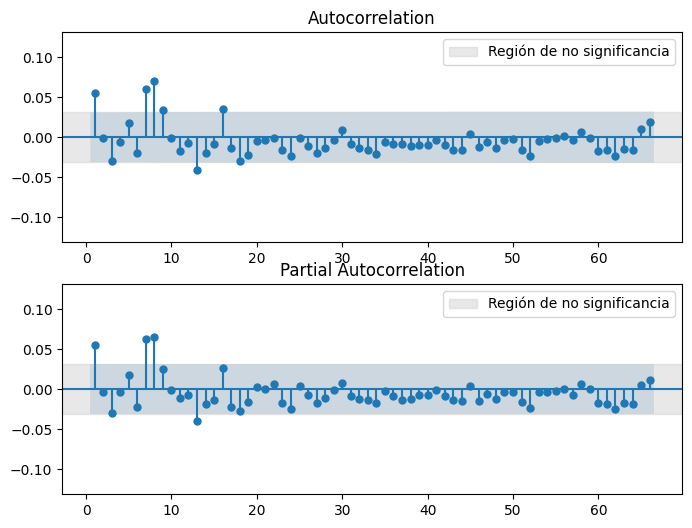

In [ ]:
residuals = res.resid

acf_pacf(y=residuals, lags=66)

Al analizar los residuos del modelo, encontramos que aún existen patrones por capturar. La presencia de retardos significativos tanto en la ACF en los retardos $[1, 3, 7, 8, 13, 16]$ como en la PACF en $[1, 3, 7, 8, 13]$, indica que los residuos no son ruido blanco.

**Predicción de los rendimientos**

Ahora vamos a hacer el mismo pronóstico que antes, pero en vez de usar los rendimientos, lo aplicaremos directamente a la serie de precios.

Para ver qué tal funciona y poder comparar, vamos a medir el error del modelo con el MAE y el RMSE porcentuales como ya explicamos en el apartado del Banco Santander.

=== Predicciones del modelo SARIMAX ===
2003-03-12    1.081666
2003-03-13    1.084709
2003-03-14    1.087385
2003-03-17    1.089585
2003-03-18    1.092455
                ...   
2014-09-03    3.740073
2014-09-04    3.740199
2014-09-05    3.740325
2014-09-08    3.740451
2014-09-09    3.740577
Freq: B, Name: predicted_mean, Length: 3000, dtype: float64

=== Intervalos de confianza ===
            lower US T-BILL SEC MARKET 3 MONTH  \
2003-03-12                            0.987917   
2003-03-13                            0.951896   
2003-03-14                            0.924437   
2003-03-17                            0.901097   
2003-03-18                            0.881683   
...                                        ...   
2014-09-03                           -0.320787   
2014-09-04                           -0.320669   
2014-09-05                           -0.320550   
2014-09-08                           -0.320432   
2014-09-09                           -0.320314   

            u

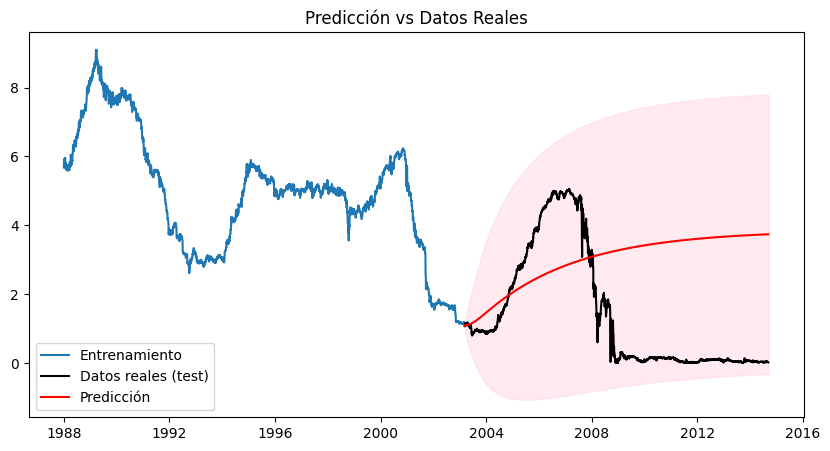

In [ ]:
pred(y_test=test_p_us_3month, y_train=train_p_us_3month_cut, modelo=res)

Los resultados de la predicción son muy deficientes, y el modelo se muestra incapaz de pronosticar el comportamiento de la serie.

La gráfica muestra una línea de predicción que sigue una tendencia suave, ignorando por completo la fuerte volatilidad de los datos reales , especialmente la caída abrupta durante la crisis de 2008.

Las métricas de error confirman esta mala predicción. Un RMSE del $33$% es elevado, pero un MAE del $93.43$% es muy alto, indicando que el modelo falla.

**Lingote de oro por onza troy:**

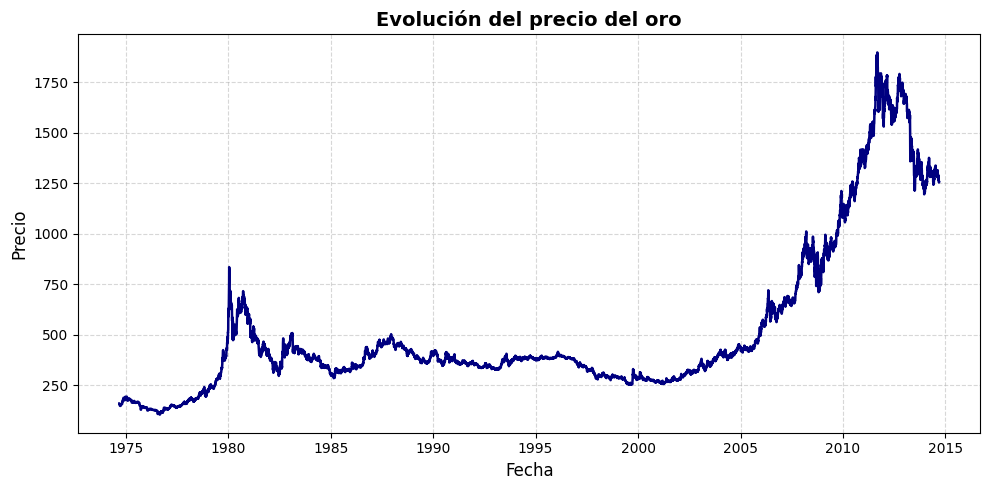

In [ ]:
plt.figure(figsize=(10,5))  # Tamaño del gráfico
plt.plot(gold, color='navy', linewidth=1.8)

plt.title("Evolución del precio del oro", fontsize=14, fontweight='bold')
plt.xlabel("Fecha", fontsize=12)
plt.ylabel("Precio", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

Vamos a hacer el contraste de Dickey Fuller para contrastar la estacionaridad de la serie.

In [ ]:
pvalue = adfuller(gold)[1]

if pvalue < 0.05: print("La serie gold es estacionaria")
else: print("La serie gold no es estacionaria")

La serie gold no es estacionaria


Como la serie no es estacionaria vamos a graficar los rendimientos para ve que serie de datos vamos a modelar.

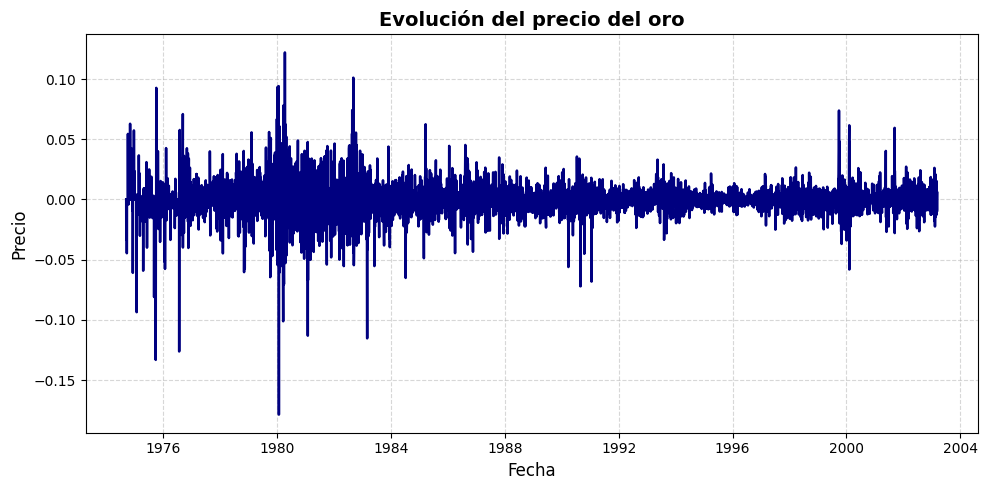

In [ ]:
plt.figure(figsize=(10,5))  # Tamaño del gráfico
plt.plot(train_gold, color='navy', linewidth=1.8)

plt.title("Evolución del precio del oro", fontsize=14, fontweight='bold')
plt.xlabel("Fecha", fontsize=12)
plt.ylabel("Precio", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

A continuación, vamos a graficar las funciones de autocorrelación (ACF) y autocorrelación parcial (PACF).

El objetivo es analizar estas gráficas para identificar qué retardos son estadísticamente significativos. Esto nos dará una primera pista sobre la estructura del modelo que podríamos utilizar.

Retardos ACF significativos: (array([ 0,  1, 12, 18, 19, 21, 23, 29, 35, 38, 41, 48, 51, 56, 62]),)
Retardos PACF significativos: (array([ 0,  1,  3,  6, 12, 19, 21, 23, 29, 35, 38, 41, 48, 49, 51, 56, 62]),)


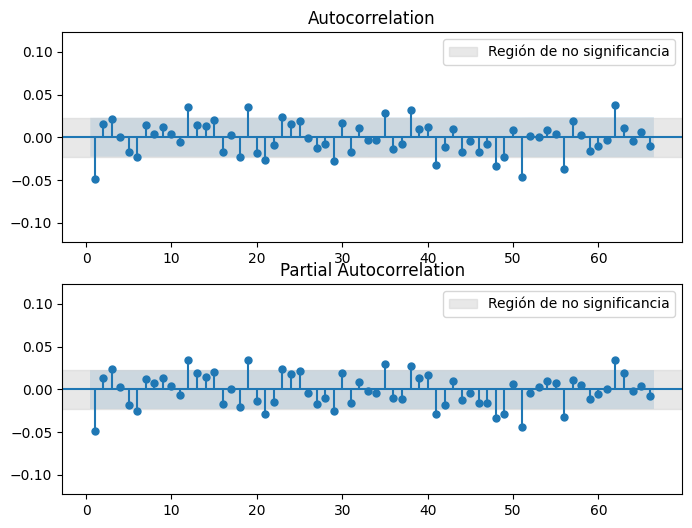

In [ ]:
acf_pacf(y=train_gold, lags=66)

El primer retardo negativo en el gráfico ACF nos da una pista para usar un modelo de Media Móvil (MA). Para refinar el modelo, incluiremos únicamente los siguientes retardos: $[0, 1, 12, 19, 21, 23, 29, 35, 38, 41, 48, 51, 56, 62]$. Estos retardos son los que han salido significativos en la ACF. Ahora vamos a estimar el modelo.

In [ ]:
q_max = 62

model = sm.tsa.SARIMAX(train_gold,
                       order=(0, 0, q_max),
                       trend='c',
                       enforce_stationarity=False,
                       enforce_invertibility=False)

allowed_ma = {'ma.L0', 'ma.L1', 'ma.L12', 'ma.L19', 'ma.L21', 'ma.L23', 'ma.L29',
 'ma.L35', 'ma.L38', 'ma.L41', 'ma.L48', 'ma.L51', 'ma.L56', 'ma.L62'}


fix_params = {}
for name in model.param_names:
    if name.startswith('ma.'):
        if name not in allowed_ma:
            fix_params[name] = 0.0

res = model.fit_constrained(fix_params, disp=False)
print(res.summary())

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 7436
Model:              SARIMAX(0, 0, 62)   Log Likelihood               21947.063
Date:                Fri, 17 Oct 2025   AIC                         -43864.127
Time:                        18:23:02   BIC                         -43760.543
Sample:                    09-10-1974   HQIC                        -43828.527
                         - 03-11-2003                                         
Covariance Type:                  opg                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
intercept       9.541e-05      0.000      0.681      0.496      -0.000       0.000
ma.L1             -0.0519      0.007     -7.749      0.000      -0.065      -0.039
ma.L2 (fixed)           0        nan

Dado que todos los retardos del modelo resultaron significativos, analizaremos los residuos para verificar si aún contienen información relevante que no ha sido capturada.

Retardos ACF significativos: (array([ 0,  5, 20]),)
Retardos PACF significativos: (array([ 0,  5, 20, 57]),)


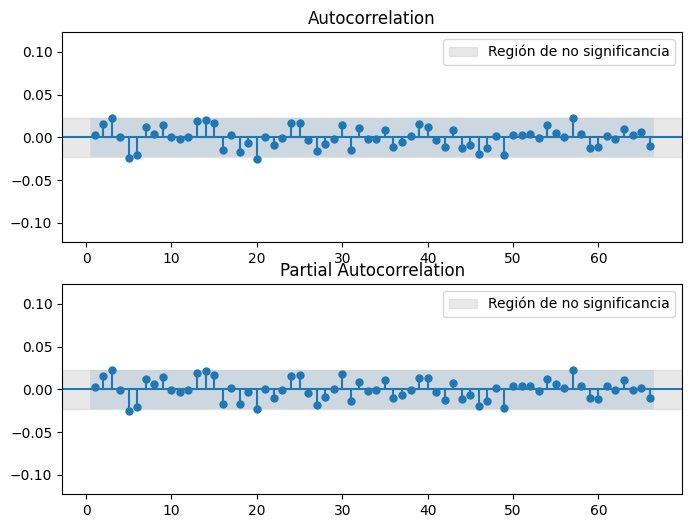

In [ ]:
residuals = res.resid

acf_pacf(y=residuals, lags=66)

El análisis de los residuos ha revelado que aún persiste información en los datos. Para capturar esta estructura de dependencia, incluiremos los retardos significativos identificados $[5, 20]$ directamente en nuestro modelo.

In [ ]:
allowed_ma = {'ma.L0', 'ma.L1', 'ma.L5', 'ma.L12', 'ma.L19','ma.L20', 'ma.L21', 'ma.L23', 'ma.L29',
 'ma.L35', 'ma.L38', 'ma.L41', 'ma.L48', 'ma.L51', 'ma.L56', 'ma.L62'}


fix_params = {}
for name in model.param_names:
    if name.startswith('ma.'):
        if name not in allowed_ma:
            fix_params[name] = 0.0


res = model.fit_constrained(fix_params, disp=False)
print(res.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 7436
Model:              SARIMAX(0, 0, 62)   Log Likelihood               21953.950
Date:                Fri, 17 Oct 2025   AIC                         -43873.900
Time:                        18:29:25   BIC                         -43756.505
Sample:                    09-10-1974   HQIC                        -43833.553
                         - 03-11-2003                                         
Covariance Type:                  opg                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
intercept       9.592e-05      0.000      0.729      0.466      -0.000       0.000
ma.L1             -0.0519      0.007     -7.661      0.000      -0.065      -0.039
ma.L2 (fixed)           0        nan

Añadimos al modelo los retardos significativos que identificamos en los residuos. Al reestimar, estos mantuvieron su significancia estadística, validando así que capturan información de los datos. Ahora vamos a revisar si queda información en los residuos.

Retardos ACF significativos: (array([0, 3]),)
Retardos PACF significativos: (array([ 0,  3, 57]),)


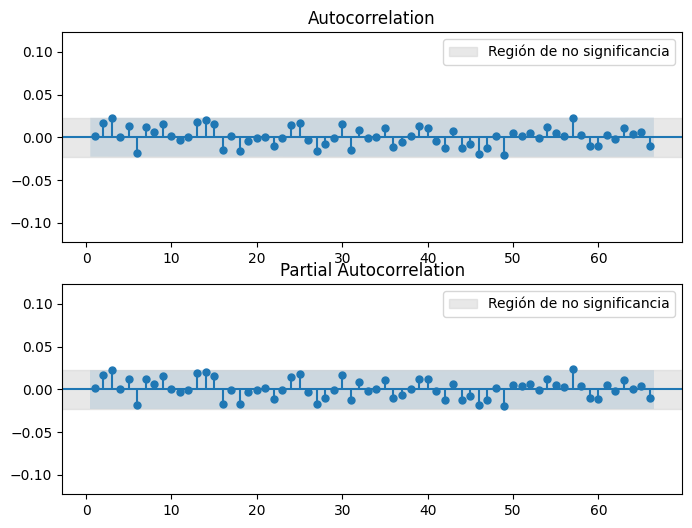

In [ ]:
residuals = res.resid

acf_pacf(y=residuals, lags=66)

Los residuos aún muestran autocorrelación. La presencia de un retardo significativo en la posición $3$ y $57$ de la ACF y la PACF nos indica que debemos añadir estos términos al modelo. Vamos a hacer este ajuste para capturar la dinámica restante.

In [ ]:
allowed_ma = {'ma.L0', 'ma.L1', 'ma.L3', 'ma.L5', 'ma.L12', 'ma.L19','ma.L20', 'ma.L21', 'ma.L23', 'ma.L29',
 'ma.L35', 'ma.L38', 'ma.L41', 'ma.L48', 'ma.L51', 'ma.L56', 'ma.L57', 'ma.L62'}


fix_params = {}
for name in model.param_names:
    if name.startswith('ma.'):
        if name not in allowed_ma:
            fix_params[name] = 0.0

res = model.fit_constrained(fix_params, disp=False)
print(res.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 7436
Model:              SARIMAX(0, 0, 62)   Log Likelihood               21958.826
Date:                Fri, 17 Oct 2025   AIC                         -43879.652
Time:                        18:47:44   BIC                         -43748.446
Sample:                    09-10-1974   HQIC                        -43834.558
                         - 03-11-2003                                         
Covariance Type:                  opg                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
intercept       9.185e-05      0.000      0.661      0.508      -0.000       0.000
ma.L1             -0.0519      0.007     -7.563      0.000      -0.065      -0.038
ma.L2 (fixed)           0        nan

Tras el ajuste del modelo, los términos que incorporamos han vuelto a resultar estadísticamente significativos. Esto confirma que el ajuste era necesario y que nuestro modelo actual captura de manera más efectiva la estructura subyacente de los datos.

Retardos ACF significativos: (array([0]),)
Retardos PACF significativos: (array([0]),)


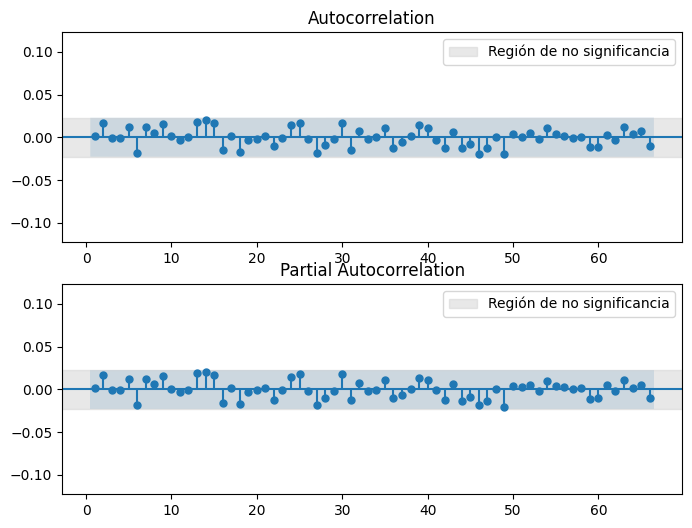

In [ ]:
residuals = res.resid

acf_pacf(y=residuals, lags=66)

El análisis de residuos confirma la validez de nuestro modelo. La ausencia de retardos significativos en la ACF y la PACF indica que los residuos se comportan como ruido blanco, por lo que hemos capturado exitosamente toda la estructura temporal de los datos.

No falta por añadir al modelo ningún retardo significativo, por lo que nos quedamos con este modelo como el óptimo, ya que los residuos no presentan autocorrelaciones significativas y los podemos considerar ruido blanco.

Denotemos $G_t $ al precio del activo (oro) en el momento  $t$ :

$$
r_t = \nabla \log(G_t)
$$

donde $r_t $ sigue un proceso $ \text{MA}(62) $ con los siguientes componentes, siendo $ \varepsilon_t $ un proceso de ruido blanco:

$$
\begin{aligned}
r_t = \varepsilon_t
&+ \theta_1 \varepsilon_{t-1} + \theta_3 \varepsilon_{t-3} + \theta_5 \varepsilon_{t-5} + \theta_{12} \varepsilon_{t-12} + \theta_{19} \varepsilon_{t-19} + \theta_{20} \varepsilon_{t-20} + \theta_{21} \varepsilon_{t-21} \\
&+ \theta_{23} \varepsilon_{t-23} + \theta_{29} \varepsilon_{t-29} + \theta_{35} \varepsilon_{t-35} + \theta_{38} \varepsilon_{t-38} + \theta_{41} \varepsilon_{t-41} + \theta_{48} \varepsilon_{t-48} \\
&+ \theta_{51} \varepsilon_{t-51} + \theta_{56} \varepsilon_{t-56} + \theta_{57} \varepsilon_{t-57} + \theta_{62} \varepsilon_{t-62}
\end{aligned}
$$

Las estimaciones de estos parámetros en el modelo final son:

$$
\begin{array}{lll}
\hat{\theta}_{1} = -0.0519 & \hat{\theta}_{21} = -0.0258 & \hat{\theta}_{41} = -0.0271 \\
\hat{\theta}_{3} = 0.0244 & \hat{\theta}_{23} = 0.0213 & \hat{\theta}_{48} = -0.0367 \\
\hat{\theta}_{5} = -0.0368 & \hat{\theta}_{29} = -0.0225 & \hat{\theta}_{51} = -0.0491 \\
\hat{\theta}_{12} = 0.0381 & \hat{\theta}_{35} = 0.0183 & \hat{\theta}_{56} = -0.0333 \\
\hat{\theta}_{19} = 0.0396 & \hat{\theta}_{38} = 0.0327 & \hat{\theta}_{57} = 0.0245 \\
\hat{\theta}_{20} = -0.0228 & & \hat{\theta}_{62} = 0.0389 \\
\end{array}
$$



**Predicción de los rendimientos**

Una vez que validamos nuestro modelo, procedimos a evaluar su capacidad predictiva. Para ello, lo utilizamos para generar un pronóstico sobre el conjunto de prueba que habíamos reservado.

Para medir la precisión de nuestras predicciones, calculamos dos métricas clave: el Error Absoluto Medio (MAE) y la Raíz del Error Cuadrático Medio (RMSE).

Finalmente, realizamos una evaluación visual. En un gráfico, comparamos los datos reales con nuestras predicciones y sus intervalos de confianza, lo que nos permitió observar directamente el rendimiento del modelo.

=== Predicciones del modelo SARIMAX ===
2003-03-12    0.001742
2003-03-13    0.000285
2003-03-14    0.000120
2003-03-17   -0.000901
2003-03-18    0.000031
                ...   
2014-09-03    0.000092
2014-09-04    0.000092
2014-09-05    0.000092
2014-09-08    0.000092
2014-09-09    0.000092
Freq: B, Name: predicted_mean, Length: 3000, dtype: float64

=== Intervalos de confianza ===
             lower y   upper y
2003-03-12 -0.022379  0.025863
2003-03-13 -0.023868  0.024439
2003-03-14 -0.024033  0.024274
2003-03-17 -0.025061  0.023260
2003-03-18 -0.024130  0.024191
...              ...       ...
2014-09-03 -0.024256  0.024440
2014-09-04 -0.024256  0.024440
2014-09-05 -0.024256  0.024440
2014-09-08 -0.024256  0.024440
2014-09-09 -0.024256  0.024440

[3000 rows x 2 columns]
MAE sobre el conjunto de prueba: 0.0084

RMSE sobre el conjunto de prueba: 0.0122
 Versión porcentual
MAE sobre el conjunto de prueba: 192.71%

RMSE sobre el conjunto de prueba:inf%


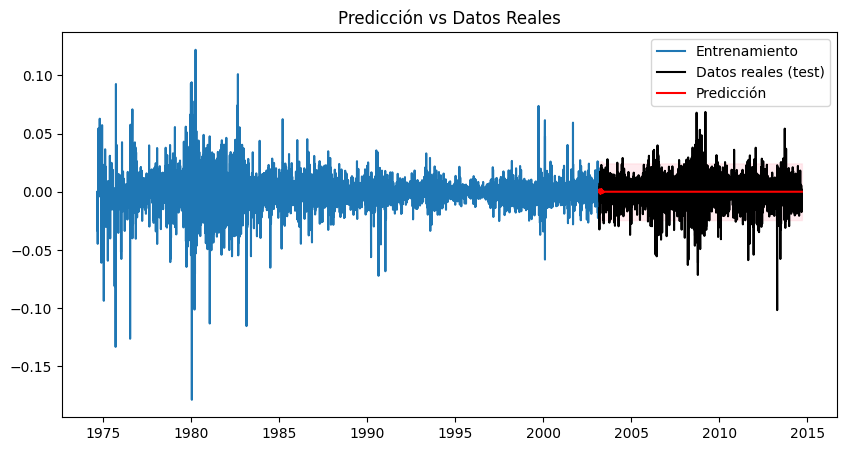

In [ ]:
pred(y_test=test_gold, y_train=train_gold, modelo=res)

Habiendo desarrollado y validado un modelo para los rendimientos del activo, ahora aplicaremos esta misma estructura de modelo directamente a la serie de precios originales.

In [ ]:
q_max = 62

model = sm.tsa.SARIMAX(train_p_gold,
                       order=(0, 0, q_max),
                       trend='c',
                       enforce_stationarity=False,
                       enforce_invertibility=False)

allowed_ma = {'ma.L0', 'ma.L1', 'ma.L5', 'ma.L12', 'ma.L19','ma.L20', 'ma.L21', 'ma.L23', 'ma.L29',
 'ma.L35', 'ma.L38', 'ma.L41', 'ma.L48', 'ma.L51', 'ma.L56', 'ma.L62'}

fix_params = {}
for name in model.param_names:
    if name.startswith('ma.'):
        if name not in allowed_ma:
            fix_params[name] = 0.0


res = model.fit_constrained(fix_params, disp=False)
print(res.summary())

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                               SARIMAX Results                                
Dep. Variable:                   Gold   No. Observations:                 7437
Model:              SARIMAX(0, 0, 62)   Log Likelihood              -40714.427
Date:                Fri, 17 Oct 2025   AIC                          81462.855
Time:                        19:05:51   BIC                          81580.252
Sample:                    09-09-1974   HQIC                         81503.203
                         - 03-11-2003                                         
Covariance Type:                  opg                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
intercept        340.2583     17.515     19.427      0.000     305.930     374.586
ma.L1              1.0382      0.034     30.649      0.000       0.972       1.105
ma.L2 (fixed)           0        nan

Al usar nuestro modelo en la serie de precios, notamos que varios retardos $(5, 21, 35, 51$ y $56)$ dejaron de ser importantes.

La razón es simple: nuestro modelo fue diseñado para los rendimientos, que son datos estables que se mueven alrededor de un punto central. En cambio, los precios no son estables, ya que tienen una tendencia general a subir o bajar a lo largo del tiempo.

Esta fuerte tendencia en los precios actúa como un "ruido" que esconde los patrones más sutiles que nuestro modelo había detectado en los rendimientos. Por eso, esos retardos pierden importancia. En resumen, el modelo no funciona bien directamente sobre los precios porque no están estabilizados como sí lo estaban los rendimientos.

Retardos ACF significativos: (array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66]),)
Retardos PACF significativos: (array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 11, 13, 14, 15, 16, 17, 18,
       19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 34, 35, 36, 37, 38,
       39, 40, 41, 42, 47, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63,
       65, 66]),)


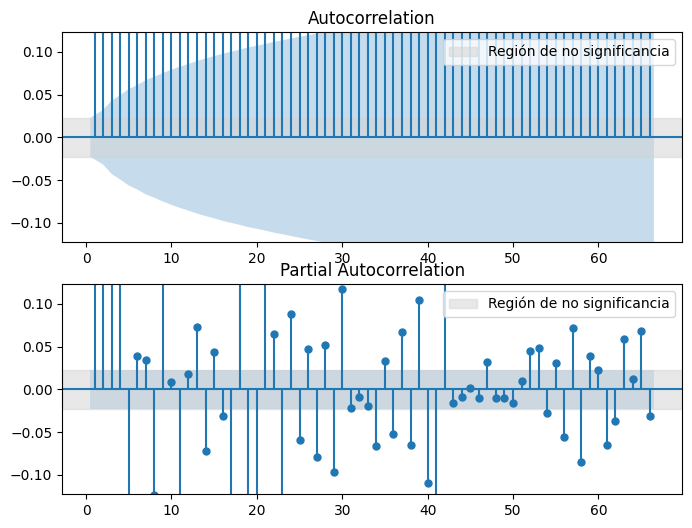

In [ ]:
residuals = res.resid

acf_pacf(y=residuals, lags=66)

Al revisar los gráficos de autocorrelación de la serie, observamos un número excesivamente alto de retardos significativos. La presencia de una estructura de correlación tan extendida es una señal clara de que el modelo no puede capturar la información de manera eficiente.

**Predicción de los precios**

Como hemos hecho con el resto de activos, vamos a estimar el modelo con la serie de precios del activo.

=== Predicciones del modelo SARIMAX ===
2003-03-12    330.084952
2003-03-13    343.423904
2003-03-14    346.537851
2003-03-17    334.792173
2003-03-18    345.399746
                 ...    
2014-09-03    340.258290
2014-09-04    340.258290
2014-09-05    340.258290
2014-09-08    340.258290
2014-09-09    340.258290
Freq: B, Name: predicted_mean, Length: 3000, dtype: float64

=== Intervalos de confianza ===
            lower Gold  upper Gold
2003-03-12  143.192814  516.977090
2003-03-13   73.971134  612.876674
2003-03-14   77.080547  615.995155
2003-03-17   65.327561  604.256786
2003-03-18   75.932889  614.866603
...                ...         ...
2014-09-03  -22.440096  702.956677
2014-09-04  -22.440096  702.956677
2014-09-05  -22.440096  702.956677
2014-09-08  -22.440096  702.956677
2014-09-09  -22.440096  702.956677

[3000 rows x 2 columns]
MAE sobre el conjunto de prueba: 622.2503

RMSE sobre el conjunto de prueba: 769.4864
 Versión porcentual
MAE sobre el conjunto de prueba: 81.24%



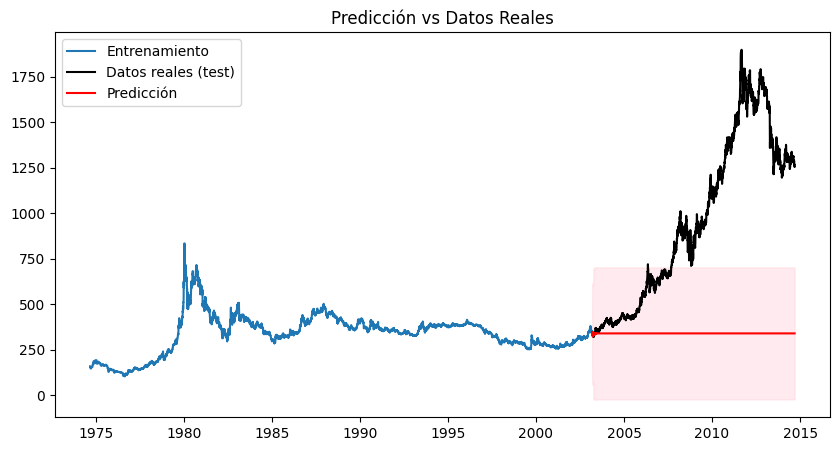

In [ ]:
pred(y_test=test_p_gold, y_train=train_p_gold, modelo=res)

Como todos los anteriores pronosticos sobre las series de los precios este pronóstico es completamente fallido y el modelo no es útil para predecir esta serie de precios.

Al igual que ocurrió en el análisis de los US Treasury Bills, el modelo es incapaz de anticipar un cambio estructural drástico. La gráfica muestra claramente que el modelo, entrenado con datos de un largo periodo de relativa estabilidad, genera una predicción totalmente plana. Esta predicción ignora por completo la subida exponencial que experimentaron los precios reales a partir de $2008$.

Las métricas de error confirman lo comentado anteriormente. Un RMSE del $54.11$% y un MAE extraordinariamente alto del $81.24$% demuestran que las predicciones están, en promedio, muy alejadas de la realidad.

**Predicciones estáticas vs dinámicas:** Por último, comentar la diferencia entre estos dos términos. En nuestro caso, las predicciones se llevan a cabo de forma estática, es decir, se predice el próximo dato y posteriormente se incorpora al conjunto de información, utilizandose para la prediccion del siguiente, y asi sucesivamente, de forma que siempre se predice un periodo (en nuestro caso, pero pueden ser $h$ periodos). En el caso de las predicciones dinamicas el conjunto de información es constante, no se actualiza con cada predicción, simplemente va variando el horizonte de previsión.

#Ejercicio 3

(a) Suponga un fondo de inversión cuyo rendimiento mensual anualizado sigue el siguiente proceso estocástico:

$$
r_t = 0.01 + 0.9 r_{t-1} + \epsilon_t \, \,, \, \,\, \hat{\sigma}_{\epsilon}^2 = 0.0004,
$$

periodicidad mensual.

Si tiene invertido $10 000$ euros, dentro de tres meses, al $99\%$ de confianza, ¿cuál será la pérdida esperada? Suponga que el rendimiento en el mes actual ha sido un $2\%$ por encima de su valor esperado incondicional.

(b) A partir de los datos del IBEX que se encuentran en la hoja de cálculo *ibex.xlsx*, especificar y estimar dos modelos ARIMA alternativos, y elija uno de ellos usando el test de Diebold y Mariano.

(c) Una vez elegido uno de los modelos ARIMA especificados en el apartado anterior, estime a partir de la distribución de las predicciones y mediante simulación, la probabilidad de que cierre el año con una ganancia respecto de la situación actual.

(d) Descargue los datos del PIB de USA de la página web de la Reserva Federal de St Louis (https://fred.stlouisfed.org/series/GDPC1). Ésta es una serie trimestral desestacionalizada en términos reales. Para no tener que tratar con el impacto de la Covid-19, elija como muestra desde el primer trimestre del $1970$ hasta el segundo trimestre de 2019. Identifique y estime un modelo ARIMA para el PIB de Estados Unidos en esa muestra. Estime, dado su modelo, con qué probabilidad el crecimiento del PIB será menor del $1\%$ en el último trimestre del año 2019.

(e) Realice una regresión entre el rendimiento spot y el rendimiento futuro del oro (los datos del precio del oro spot y futuro están en la hoja de cálculo *precios_oro.xlsx*), añadiendo un modelo ARMA para los residuos, si fuera necesario, y contraste si el rendimiento del futuro del oro es un predictor del rendimiento spot futuro.


**Apartado a)**

Debemos obtener un intervalo de confianza al 99% para $r_{t+3}$, para lo que calculamos su esperanza y varianza: \
$E_T [r_{T+3}] = \mu + \varphi E_T [r_{T+2}] + E_T [\epsilon_{T+2}] = \mu + \varphi (\mu + \varphi E_T [r_{T+1}]) = (1+\varphi)\mu + \varphi^2 \mu + \varphi r_T = (1 + \varphi + \varphi^2)\mu + \varphi r_T $\
$V_T [r_{T+3}] = \phi^2 V_T [r_{T+2}] + \sigma_{\epsilon}^2 = \varphi^2 (\varphi^2 V_T [r_{T+1}] + \sigma_{\epsilon}^2) + \sigma_{\epsilon}^2 = \varphi^4 V_T [r_{T+1}] + \varphi^2 \sigma_{\epsilon}^2 + \sigma_{\epsilon}^2 = \sigma_{\epsilon}^2 ( 1+ \varphi^2 + \varphi^4)$

Por tanto, asumiendo normalidad de los shocks ($\epsilon_t$), el rendimiento mensual acumulado anualizado en el peor de los casos al 99% de confianza es el siguiente:\
$ E_T[r_{T+3}] - 2.33 \sqrt{V_T[r_{T+3}]}]
\;\;\rightarrow\;\;
[(1 + \varphi + \varphi^2)\mu + \varphi^3 r_T] - 2.33 \, \sqrt{\sigma_\epsilon^2(1 + \varphi^2 + \varphi^4)}$

Además sabemos que el valor esperado condicional es: \
$E[r_t] = \mu + \varphi E[r_{t-1}]  \Rightarrow E[r_t] = \frac{\mu}{1-\varphi} ,  $ por lo que $r_T = E[r_t] + 0.02   $

Sustituyendo los valores de los parámetros:

In [ ]:
mu = 0.01
varphi = 0.9
sigma_2 = 0.0004

# Esperanza incondiconal
E_rt = mu / (1 - varphi)

# Rendimiento mes actual (T)
R_T = E_rt + 0.02

# Intervalo de confianza:
# Esperanza
E = (1 + varphi + varphi**2) * mu + varphi**3 * R_T
# Varianza
V = np.sqrt(sigma_2 * (1 + varphi**2 + varphi**4))
IC = [E - 2.33 * V, E + 2.33 * V]

# Peor rendimiento mensual anualizado al 99% de confianza
R = IC[0]

print(f'El peor rendimiento (anualizado) en t = T + 3 con el 99% de confianza es del {np.round(R*100, 2)}%,'
      f' por lo que el valor de la cartera será de {np.round(10000 * (1 + R)**(3/12), 2)}€')

El peor rendimiento (anualizado) en t = T + 3 con el 99% de confianza es del 4.14%, por lo que el valor de la cartera será de 10101.93€


**Apartado b)**

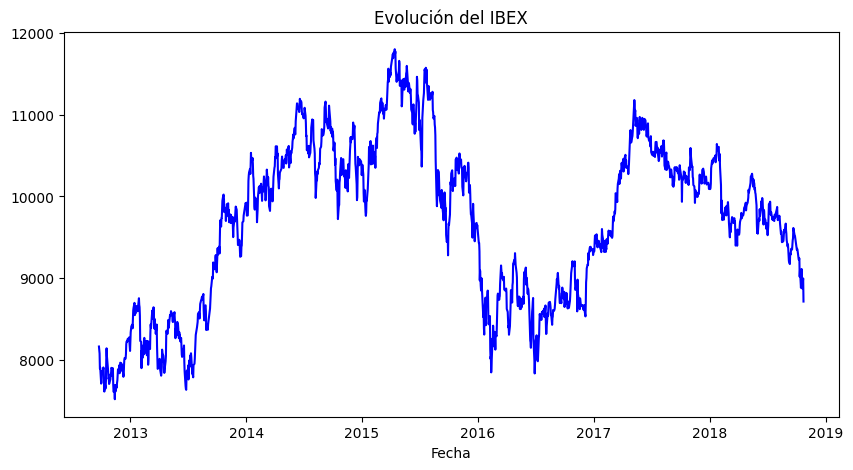

In [ ]:
ibex = pd.read_csv("datos_ej3.csv", sep=";", header=None, names=['Date', 'Apertura'])
ibex['Date'] = pd.to_datetime(ibex['Date'], dayfirst=True)
ibex['Apertura'] = ibex['Apertura'].astype(str).str.replace(',', '.').astype(float)
ibex = ibex.set_index('Date')

plt.figure(figsize=(10,5))
plt.plot(ibex.index, ibex['Apertura'], label='Apertura', color='blue')
plt.title('Evolución del IBEX')
plt.xlabel('Fecha')
plt.show()

Esta serie es claramente no estacionaria, por lo que tomamos la primera diferencia del logaritmo, los rendimientos.

Text(0.5, 1.0, 'Rendimientos del IBEX')

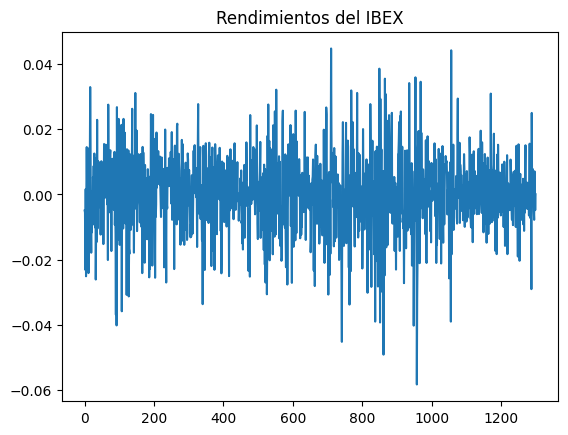

In [ ]:
ibex_return_T = np.diff(np.log(ibex["Apertura"]))
ibex_return = ibex_return_T[:-255]  # eliminamos las ultimas 100 observaciones para evaluar la capacidad predictiva mas adelante
plt.plot(ibex_return)
plt.title("Rendimientos del IBEX")

Llevamos a cabo el contraste de Dickey-Fuller para confirmar la estacionariedad de los rendimientos.

In [ ]:
pvalue = adfuller(ibex_return)[1]

if pvalue < 0.05: print("La serie d_gdp es estacionaria")
else: print("La serie d_gdp no es estacionaria")

La serie d_gdp es estacionaria


Retardos ACF significativos: (array([ 0,  4,  5, 12, 17, 57]),)
Retardos PACF significativos: (array([ 0,  4,  5, 12, 17]),)


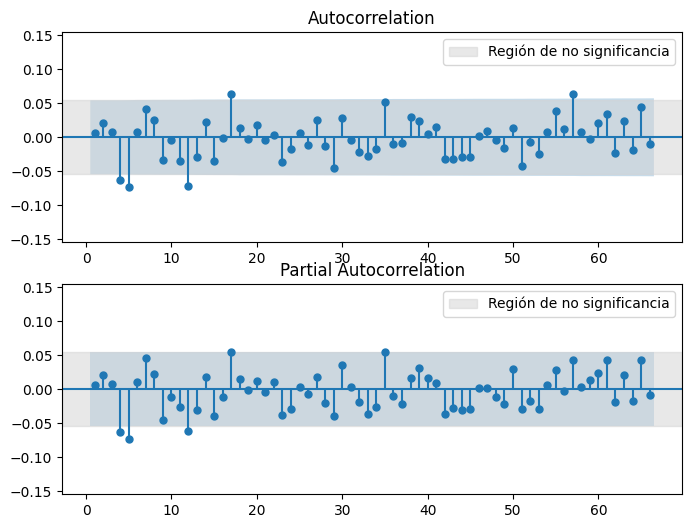

In [ ]:
ibex_return = pd.Series(ibex_return)
acf_pacf(ibex_return, 66)

Observamos que tanto la acf como la pacf presentan los retardos 4, 5, 12 y 17 significativos, asi como 35 y 57 tan solo lo son en una de ellas, pese a presentar una autocorrelación cerca de bandas en la otra gráfica. Por tanto, comenzamos estimando un AR con los retardos comunes y vemos que en los residuos aun queda cierta estructura autorregresiva, que son precisamente los retardos 35 y 57. Al incluir estos dos ultimos en el modelo autorregresivo, los residuos se comportan como un ruido blanco.

In [ ]:
p_max = 57
model = sm.tsa.SARIMAX(ibex_return,
                       order=(p_max, 0, 0),
                       trend='c',
                       enforce_stationarity=False,
                       enforce_invertibility=False)


allowed_ar = {'ar.L4', 'ar.L5', 'ar.L12', 'ar.L17', 'ar.L35', 'ar.L57'}

fix_params = {}
for name in model.param_names:
    if name.startswith('ar.'):
        if name not in allowed_ar:
            fix_params[name] = 0.0

model1 = model.fit_constrained(fix_params, disp=False)

print(model1.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1300
Model:              SARIMAX(57, 0, 0)   Log Likelihood                3746.433
Date:                Fri, 17 Oct 2025   AIC                          -7476.867
Time:                        19:13:01   BIC                          -7435.865
Sample:                             0   HQIC                         -7461.448
                               - 1300                                         
Covariance Type:                  opg                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
intercept          0.0002      0.000      0.568      0.570      -0.000       0.001
ar.L1 (fixed)           0        nan        nan        nan         nan         nan
ar.L2 (fixed)           0        nan

Retardos ACF significativos: (array([0]),)
Retardos PACF significativos: (array([0]),)


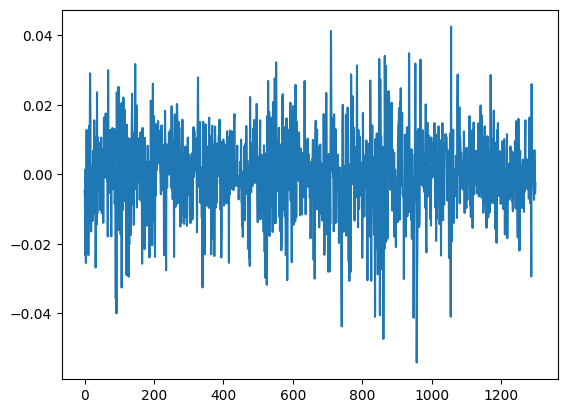

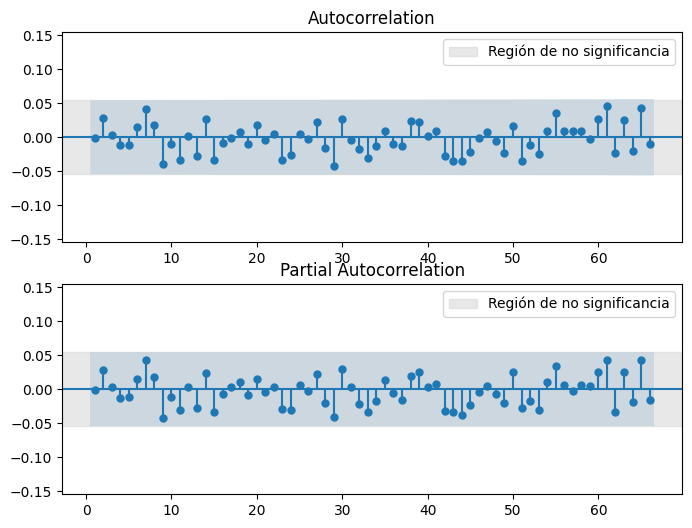

In [ ]:
resid1 = model1.resid
plt.plot(resid1)
acf_pacf(resid1, 66)

Por tanto, este sería el modelo "correcto" para los rendimientos del IBEX-35. Vamos a comparar el poder predictivo de este modelo con uno mas simple: un AR con los retardos 4 y 5. Así podremos observar si aumentar la complejidad del modelo incluyendo mas retardos que los dos primeros que resultan significativos en la ACF y PACF mejora las predicciones.

Modelo 1: $r_{t} = \alpha + \varphi_4 r_{t-4} + \varphi_5 r_{t-5} +\varphi_{12} r_{t-12} +\varphi_{17} r_{t-17}
+\varphi_{35} r_{t-35} +\varphi_{57} r_{t-57} + \epsilon_t$\
Modelo 2: $r_{t} = \alpha + \varphi_4 r_{t-4} + \varphi_5 r_{t-5} + \epsilon_t$

In [ ]:
p_max = 5
model = sm.tsa.SARIMAX(ibex_return,
                       order=(p_max, 0, 0),
                       trend='c',
                       enforce_stationarity=False,
                       enforce_invertibility=False)


allowed_ar = {'ar.L4', 'ar.L5'}

fix_params = {}
for name in model.param_names:
    if name.startswith('ar.'):
        if name not in allowed_ar:
            fix_params[name] = 0.0
# Fit with constraints (constrained MLE)
model2 = model.fit_constrained(fix_params, disp=False)

print(model2.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1300
Model:               SARIMAX(5, 0, 0)   Log Likelihood                3896.421
Date:                Fri, 17 Oct 2025   AIC                          -7784.842
Time:                        19:13:09   BIC                          -7764.177
Sample:                             0   HQIC                         -7777.087
                               - 1300                                         
Covariance Type:                  opg                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
intercept         0.0002      0.000      0.687      0.492      -0.000       0.001
ar.L1 (fixed)          0        nan        nan        nan         nan         nan
ar.L2 (fixed)          0        nan     

Test Diebold y Mariano (h=1, M=255 (observaciones durante el ultimo año)):

In [ ]:
# Predicciones de ambos modelos
model1_prediccion = model1.forecast(steps=255)
model2_prediccion = model2.forecast(steps=255)

# Errores de prediccion
model1_error = model1_prediccion - ibex_return_T[-255:]
model2_error = model2_prediccion - ibex_return_T[-255:]

# Calcular valor del estadistico DM
d = np.abs(model1_error) - np.abs(model2_error)
d_mean = np.mean(d)
d_centered = d - d_mean
T = len(d)
h = 1
gamma = acovf(d_centered, fft=False, nlag=h-1)
var_d = gamma[0] + 2 * np.sum(gamma[1:h])
DM = d_mean / np.sqrt(var_d / T)
print("Estadístico Diebold-Mariano:", np.round(DM, 5))

# Regla de decisión
if DM > 1.96: print("El modelo 2 tiene mejor capacidad predictiva")
elif DM < -1.96: print("El modelo 1 tiene mejor capacidad predictiva")
else: print("No hay un modelo mejor que otro en cuanto a predicción")

Estadístico Diebold-Mariano: -0.55674
No hay un modelo mejor que otro en cuanto a predicción


Dado que el modelo 1, pese a estar a priori mejor especificado, no tiene una mejor capacidad predictiva, nos quedamos con el modelo 2 que tan solo incorpora 2 retardos, lo que simplifica el trabajo y la computación.

**Apartado c)**

In [ ]:
N = 10000
horizon = 255  # pasos a simular

# Inicializamos matrices para guardar resultados
return_sim = np.zeros((horizon, N))

# Últimos 5 datos de la serie
Y0 = ibex_return[-5:]

for i in range(N):
    # Simulamos h pasos adelante
    sim = model2.simulate(horizon, anchor='end', initial_state=Y0)

    # Guardamos los retornos simulados
    return_sim[:, i] = sim

prob = np.mean(return_sim[-1, :] > 0)

print("Probabilidad de cerrar el año en positivo:", prob)

Probabilidad de cerrar el año en positivo: 0.5015


**Apartado d)**

Text(0.5, 1.0, 'Real GDP')

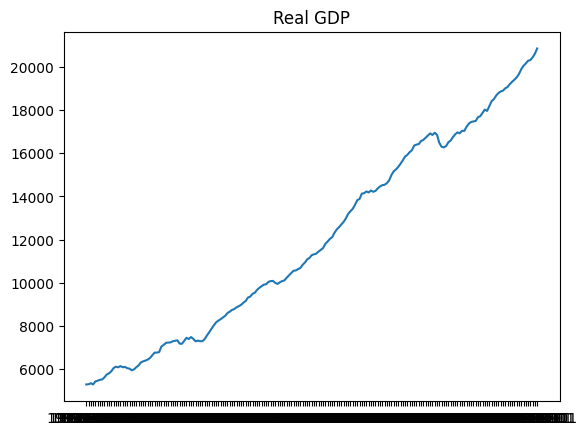

In [ ]:
gdp = pd.read_csv("GDPC1.csv", index_col=0)

plt.plot(gdp)
plt.title("Real GDP")

La serie claramente no es estacionaria, por lo que tomamos la primera diferencia del logaritmo, que elimina tanto estacionariedad en media, como posible heterocedasticidad. De esta forma, tenemos la tasa de crecimiento del PIB.

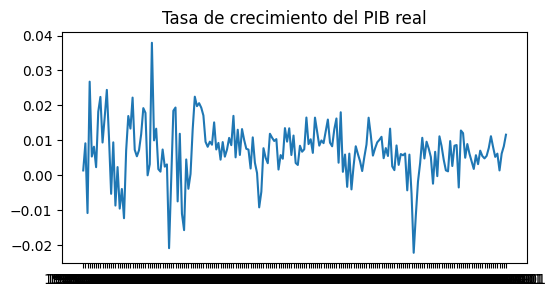

In [ ]:
ln_gdp = np.log(gdp)
lnd_gdp = ln_gdp.diff().dropna()

plt.figure(figsize=(6,3))
plt.plot(lnd_gdp)
plt.title("Tasa de crecimiento del PIB real")
plt.show()

Graficamente no esta claro si la serie es estacionaria, por lo que llevamos a cabo el test de Dickey-Fuller.

In [ ]:
pvalue = adfuller(lnd_gdp)[1]

if pvalue < 0.05: print("La serie lnd_gdp es estacionaria")
else: print("La serie d_gdp no es estacionaria")

La serie lnd_gdp es estacionaria


Además, incluimos dos variables binarias que toman valor uno en momentos en los que el crecimiento/descenso del PIB fue de un tamaño siginificarivamente mas alto que en el resto de la muestra, de forma que al incluirlo en el modelo ARIMA no influya en la estructura temporal de la serie.

$shock_+ =
\begin{cases}
1, & \text{si } \Delta \ln GDP_t > 0.03\\
0, & \text{si } \Delta \ln GDP_t < 0.03
\end{cases}
$

$shock_- =
\begin{cases}
1, & \text{si } \Delta \ln GDP_t < -0.015\\
0, & \text{si } \Delta \ln GDP_t > -0.015
\end{cases}
$

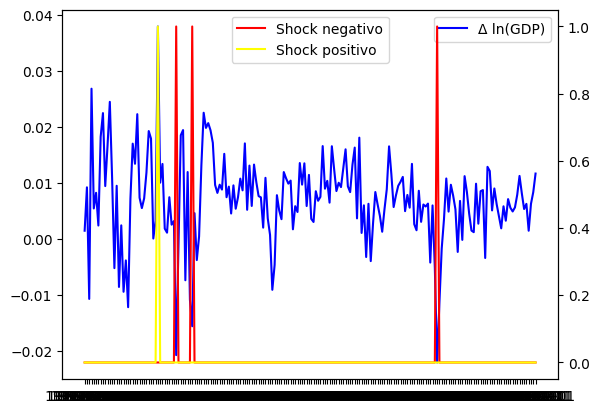

In [ ]:
shock_neg = (lnd_gdp < -0.015).astype(int)
shock_pos = (lnd_gdp > 0.03).astype(int)
fig, ax1 = plt.subplots()

ax1.plot(lnd_gdp.index, lnd_gdp.values, label="Δ ln(GDP)", color='blue')
plt.legend()

ax2 = ax1.twinx()
ax2.plot(shock_neg.values, label="Shock negativo", color='red')
ax2.plot(shock_pos.values, label="Shock positivo", color='yellow')
plt.legend()

plt.show()

shocks = pd.concat([shock_neg, shock_pos], axis=1)
shocks.columns = ['shock_neg', 'shock_pos']

Una vez tenemos una serie estacionaria, observamos sus funciones de autocorrelación simple y parcial (20 retardos, es decir, 5 años de dependencia) para analizar su estructura de dependencia temporal.

Retardos ACF significativos: (array([ 0,  1,  2,  8, 12]),)
Retardos PACF significativos: (array([ 0,  1,  2,  8,  9, 12]),)


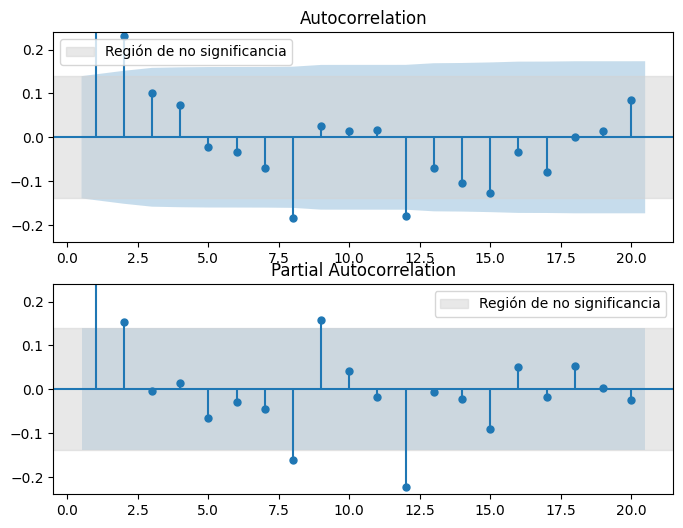

In [ ]:
acf_pacf(lnd_gdp, 20)

In [ ]:
p_max = 12
model = sm.tsa.SARIMAX(lnd_gdp,
                       order=(p_max, 0, 0),
                       trend='c',
                       exog = shocks,
                       enforce_stationarity=False,
                       enforce_invertibility=False)


allowed_ar = {'ar.L1', 'ar.L2', 'ar.L12'}

fix_params = {}
for name in model.param_names:
    if name.startswith('ar.'):
        if name not in allowed_ar:
            fix_params[name] = 0.0
# Fit with constraints (constrained MLE)
resultados = model.fit_constrained(fix_params, disp=False)

print(resultados.summary())

params = resultados.params

alpha_0 = params[0]
alpha_1 = params[3]
alpha_2 = params[4]
alpha_12 = params[14]
sigma = params[14]


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                  GDPC1   No. Observations:                  198
Model:              SARIMAX(12, 0, 0)   Log Likelihood                 689.780
Date:                Fri, 17 Oct 2025   AIC                          -1365.559
Time:                        19:13:54   BIC                          -1342.979
Sample:                    04-01-1970   HQIC                         -1356.409
                         - 07-01-2019                                         
Covariance Type:                  opg                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
intercept          0.0046      0.001      5.572      0.000       0.003       0.006
shock_neg         -0.0214      0.005     -4.666      0.000      -0.030      -0.012
shock_pos          0.0289      0.007

/tmp/ipython-input-1200441265.py:24: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  alpha_0 = params[0]
/tmp/ipython-input-1200441265.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  alpha_1 = params[3]
/tmp/ipython-input-1200441265.py:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  alpha_2 = params[4]
/tmp/ipython-input-1200441265.py:27: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future ve

Retardos ACF significativos: (array([0]),)
Retardos PACF significativos: (array([0]),)


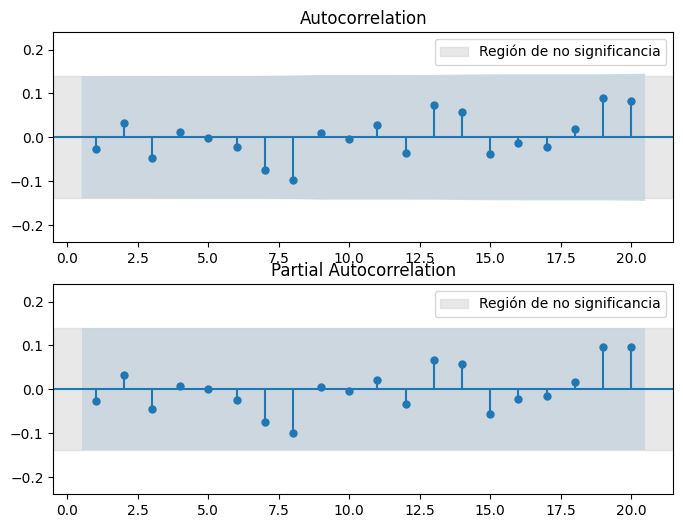

In [ ]:
residuos = resultados.resid
acf_pacf(residuos, 20)

El modelo estimado es, por tanto, un ARIMA(12, 1, 0) con los retardos autorregreivos 1, 2, y 12, por lo que podemos intuir una  fuerte dependencia a corto plazo y, en menor medida, tambien a largo plazo. Este ultimo retardo, pese a resultar no significativo al 5% de significación (si lo es al 10%) permite la no autocorrelación de los residuos quedando un ruido blanco, por lo que no se puede extraer mas información. De lo contrario, los residuos tienen el retardo 12 de la PACF significativo. Además, como hemos explicado anteriormente, el modelo incluye dos variables binarias que toman valor 1 en los momentos del tiempo en los que la tasa de crecimiento del PIB fue muy alta o baja. De forma que el modelo queda de la siguiente forma:\
\
$\Delta \ln(GDP_t) = 0.05 + 0.24 \Delta \ln(GDP_{t-1}) + 0.20 \Delta \ln(GDP_{t-2}) - 0.11 \Delta \ln(GDP_{t-12}) + 0.03 shock^{+}_t - 0.02 shock^{-}_t + \epsilon_t$

Tal y como es de esperar, el coeficiente de las variables binarias es positivo en el caso del shock positivo y negativo en el del shock negativo. Además, observamos unos fenomen similar al momentum y reversión de la renta variable, siendo los coeficientes positivos para los retardos de corto plazo (1 y 2), y negativo para el largo plazo (12). De la misma forma, se puede interpretar como la influencia del ciclo económico, con periodos de expansión seguidos de periodos de contracción.

Ahora, con el objetivo de estimar probabilidad de que el crecimiento del PIB sea menor del 1% en el último trimestre del año 2019, debemos obtener la distribución de $\Delta \ln (GDP_{T+2}) | \Omega_{T}$ que por simplicidad vamos a renombrar a $X_{T+2}$.

Esperanza de $X_{T+2}$:

$E_T[X_{T+2}] = \alpha_0 + \alpha_1 E_T[X_{T+1}] + \alpha_2 X_T + \alpha_{12} E_T[X_{T-10}]
= \alpha_0 + \alpha_1 (\alpha_0 + \alpha_1 X_T + \alpha_2 X_{T-1} + \alpha_{12} X_{T-11}) + \alpha_2 X_T + \alpha_{12} X_{T-10}
= \alpha_0 (1 + \alpha_1) + (\alpha_1^2 + \alpha_2) X_T + (\alpha_1 \alpha_2) X_{T-1} + (\alpha_1 \alpha_{12}) X_{T-11} + \alpha_{12} X_{T-10}$

In [ ]:
E_T_XT2 = (alpha_0 * (1 + alpha_1) + (alpha_1**2 + alpha_2) * lnd_gdp.iloc[-1] + alpha_1 * alpha_2 * lnd_gdp.iloc[-2]
    + alpha_1 * alpha_12 * lnd_gdp.iloc[-12] + alpha_12 * lnd_gdp.iloc[-11])

Varianza de $X_{T+2}$:

$e_T(2) = X_{T+2} - E_T[X_{T+2}] = \alpha_0 - (1-\alpha_0)\alpha_1 + \alpha_1 X_{T+1} + \alpha_1^2 X_T - (\alpha_1 \alpha_2) X_{T-1} - (\alpha_1 \alpha_{12}) X_{T-12} + \epsilon_{T+2}  + \alpha_1 \epsilon_{T+1}  $\
Por tanto: $Var(e_T(2)) = Var(\alpha_1 X_{T+1} + \epsilon_{T+2} + \alpha_1 \epsilon_{T+1}) = \alpha_1^2 Var(X_{T+1}) + \sigma_{\epsilon}^2 + \alpha_1 \sigma_{\epsilon}^2 = (\alpha_1^2 + \alpha_1 )\epsilon_{T+1} + \sigma_{\epsilon}^2$

In [ ]:
# (asumiendo estacionariedad en varianza)
V_T_XT2 = (alpha_1**2 + alpha_1) * sigma**2 + sigma**2

In [ ]:
prob = norm.cdf((0.01 - E_T_XT2) / np.sqrt(V_T_XT2))
prob_value = prob.item()
E_T_XT2_value = E_T_XT2.item()
V_T_XT2_value = V_T_XT2.item()
print(f"Probabilidad de X_T+2 < 1%: {prob_value * 100:.4f}%")
print(f"Esperanza condicional de X_T+2: {E_T_XT2_value * 100:.5f}%")
print(f"Varianza condicional de X_T+2: {V_T_XT2_value * 100:.5f}%")

Probabilidad de X_T+2 < 1%: 50.5275%
Esperanza condicional de X_T+2: 0.83652%
Varianza condicional de X_T+2: 1.52862%


$P(X_{T+2} \leq 0.01) = P\left(\frac{X_{T+2} - E_T(X_{T+2})}{\sqrt{V_T({X_{T+2}})}} \leq \frac{0.01 - E_T(X_{T+2})}{\sqrt{V_T({X_{T+2}})}}\right) = N\left(\frac{0.01 - E_T(X_{T+2})}{\sqrt{V_T({X_{T+2}})}}\right) = 0.50527478$\
Asumiento normalidad de los residuos y con una esperanza de la tasa de crecimiento de un 0,8% y varianza de 1,5%, la probabilidad de que la tasa de crecimiento dentro de dos periodos, en el último trimestre del año 2019, sea menor del 1% es del 50,53%.

**Apartado e)**

In [ ]:
precios = pd.read_csv("datos_ej3_oro.csv", sep=";")
precios["Spot"] = precios["Spot"].str.replace(",", ".").astype(float)
precios["Futuro"] = precios["Futuro"].str.replace(",", ".").astype(float)

returns = pd.DataFrame()
returns["Spot"] = np.diff(np.log(precios["Spot"]))
returns["Futuro"] = np.diff(np.log(precios["Futuro"]))

Llevamos a cabo la regresión
$r_t^s = \alpha + \beta r_t^f + u_t$

In [ ]:
Y = returns["Spot"]
X = returns["Futuro"]
X = sm.add_constant(X)

regresion = sm.OLS(Y, X).fit()

print(regresion.summary())

                            OLS Regression Results                            
Dep. Variable:                   Spot   R-squared:                       0.674
Model:                            OLS   Adj. R-squared:                  0.673
Method:                 Least Squares   F-statistic:                     3829.
Date:                Fri, 17 Oct 2025   Prob (F-statistic):               0.00
Time:                        19:14:08   Log-Likelihood:                 6445.8
No. Observations:                1858   AIC:                        -1.289e+04
Df Residuals:                    1856   BIC:                        -1.288e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       6.667e-05      0.000      0.381      0.7

Retardos ACF significativos: (array([ 0,  1,  9, 10, 13, 14, 29, 30, 44]),)
Retardos PACF significativos: (array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 12, 13, 26, 28, 39, 42, 43]),)


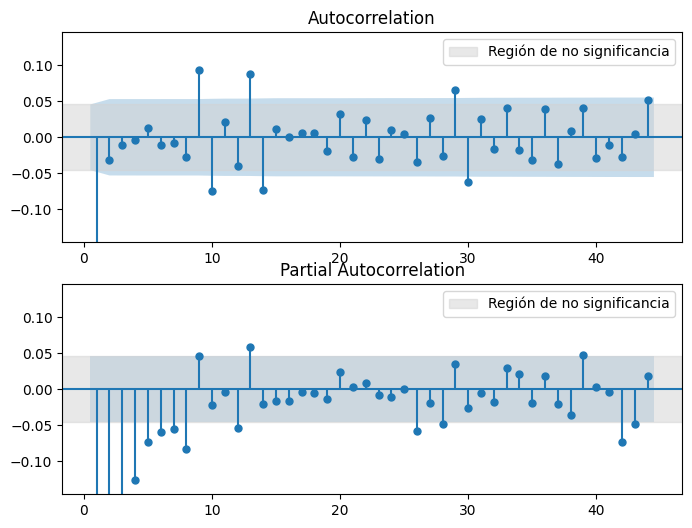

In [ ]:
residuos = regresion.resid
acf_pacf(residuos, 44)

Los residuos de la regresión, como podemos observar, no se comportan como un ruido blanco, lo que invalida la inferencia clásica. Por tanto, vamos a determinar la estructura temporal de estos residuos, para así incluirla en el modelo.

In [ ]:
p_max = 44
model = sm.tsa.SARIMAX(residuos,
                       order=(p_max, 0, 1),
                       trend='c',
                       enforce_stationarity=False,
                       enforce_invertibility=False)


allowed_ar = {'ar.L9', 'ar.L13', 'ar.L14','ar.L26','ar.L29','ar.L30','ar.L40','ar.L41','ar.L42','ar.L44'}

fix_params = {}
for name in model.param_names:
    if name.startswith('ar.'):
        if name not in allowed_ar:
            fix_params[name] = 0.0

# Fit with constraints (constrained MLE)
model_residuos = model.fit_constrained(fix_params, disp=False)


print(model_residuos.summary())
residuos2 = model_residuos.resid

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1858
Model:              SARIMAX(44, 0, 1)   Log Likelihood                6611.282
Date:                Fri, 17 Oct 2025   AIC                         -13196.564
Time:                        19:15:24   BIC                         -13125.021
Sample:                             0   HQIC                        -13170.165
                               - 1858                                         
Covariance Type:                  opg                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
intercept      -6.629e-06   5.35e-05     -0.124      0.901      -0.000    9.82e-05
ar.L1 (fixed)           0        nan        nan        nan         nan         nan
ar.L2 (fixed)           0        nan

Retardos ACF significativos: (array([0]),)
Retardos PACF significativos: (array([0]),)


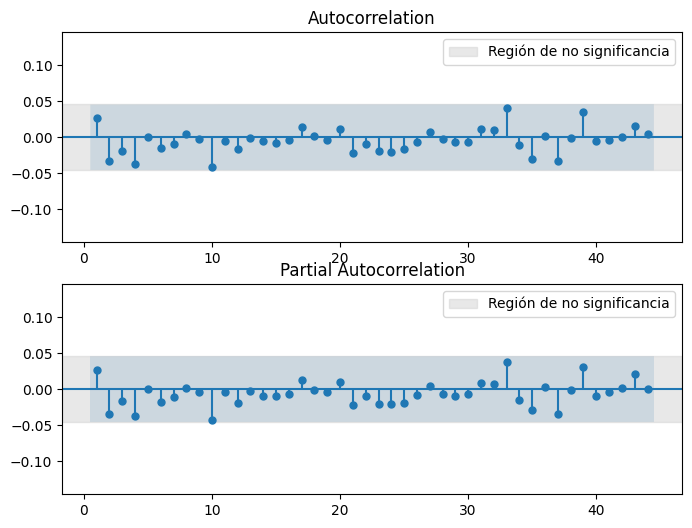

In [ ]:
acf_pacf(residuos2, 44)

Los residuos de la regresión del rendimiento spot sobre el futuro siguen el modelo:\
$ u_t = \alpha + \phi_{9} u_{t-9}+ \phi_{13} u_{t-13}+ \phi_{14} u_{t-14}+ \phi_{26} u_{t-26}+ \phi_{29} u_{t-29}+ \phi_{30} u_{t-30}
    + \phi_{40} u_{t-40}+ \phi_{41} u_{t-41}+ \phi_{42} u_{t-42}+ \phi_{44} u_{t-44}+ \varepsilon_t+ \theta_1 \varepsilon_{t-1}. $\
Incluyendo este estructura de dependencia en la regresión original, podriamos llevar a cabo inferencia, pues se cumplen el supuesto de no autocorrelación. Sin embargo, no existe ninguna libreria que permita llevar a cabo esta estimación conjunta, por lo que llevaremos a cabo en contraste de hipotesis conjunto $H_0: \alpha=0,  \beta=1$ usando la correción de Newey-West, que estima la matriz de varianzas y covarianzas de los residuos ($u_t$), permitiendo llevar a cabo contrastes válidos asintoticamente.

In [ ]:
# Matriz de covarianzas Newey-West
cov_hac_matrix = cov_hac_simple(regresion, nlags=44)

# Test conjunto H0: alpha=0, beta=1
R = np.array([[1, 0],
              [0, 1]])
q = np.array([0, 1])

beta_hat = regresion.params
diff = R @ beta_hat - q

# Estadístico de Wald
W = diff.T @ np.linalg.inv(R @ cov_hac_matrix @ R.T) @ diff
p_value = 1 - chi2.cdf(W, df=2)

print(f"\nEstimación de alpha: {np.round(beta_hat[0], 4)}"
      f' y beta: {np.round(beta_hat[1], 4)}')
print("Estadístico de Wald:", W)
print("p-valor:", p_value)



Estimación de alpha: 0.0001 y beta: 0.8256
Estadístico de Wald: 55.92093132868349
p-valor: 7.193134976546389e-13


/tmp/ipython-input-4097433152.py:16: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(f"\nEstimación de alpha: {np.round(beta_hat[0], 4)}"
/tmp/ipython-input-4097433152.py:17: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  f' y beta: {np.round(beta_hat[1], 4)}')


$Pvalue < 0.01$, por tanto, rechazamos la hipótesis nula de que el futuro del oro es un predictor (un estimador insesgado) de su precio spot con un nivel de confianza del 99%.